# Load

In [1]:
datadir <- '/n/scratch3/users/i/ik97/'

In [2]:
suppressWarnings({
    source('utils_celldive.R')    
})


# Label Niches

In [3]:
spots <- readRDS(glue('{datadir}/gut_spots.rds'))
cells <- readRDS(glue('{datadir}/gut_cells.rds'))


## Plot clusters

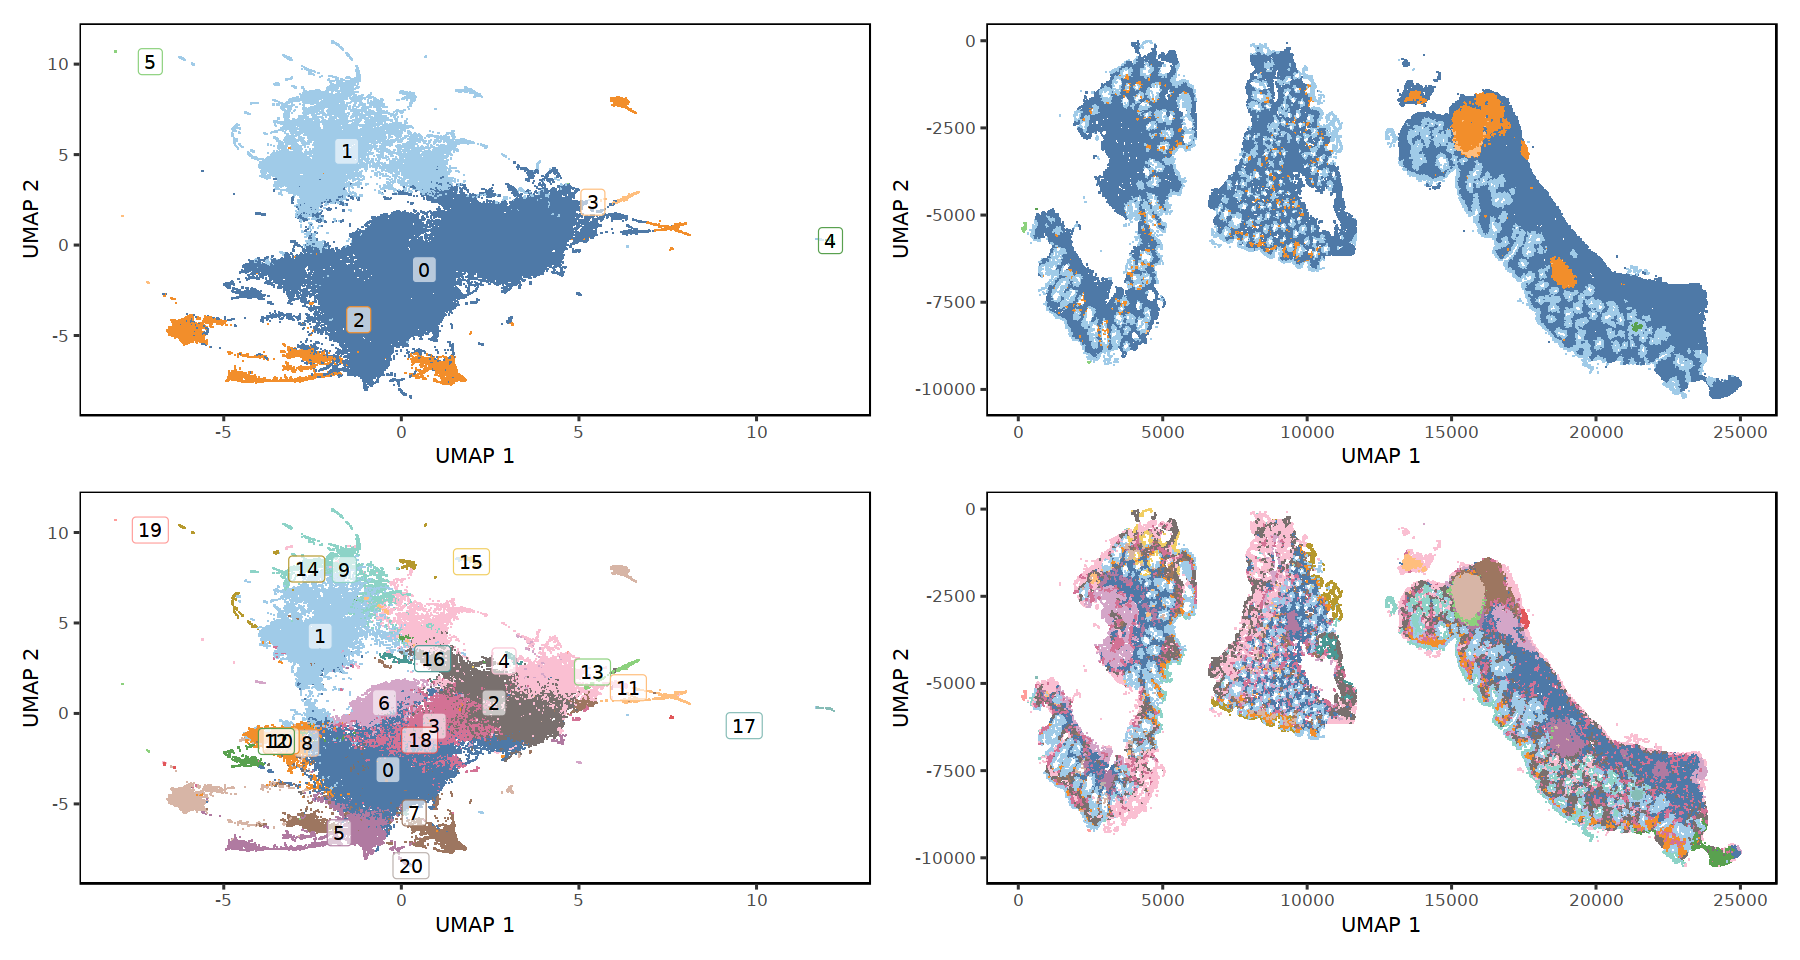

In [4]:
with(spots, {
    clusters_plot <- names(which(Clusters %>% map(table) %>% map_int(length) <= length(colors_overload)))
    fig.size(4 * length(clusters_plot), 15)
    map(clusters_plot, function(.name) {
        do_scatter(U1$embedding, Clusters, .name) |
        do_scatter(data.frame(x = metadata$y, y = -metadata$x), Clusters, .name, do_labels = FALSE)
    }) %>% 
        reduce(`/`)
    
})


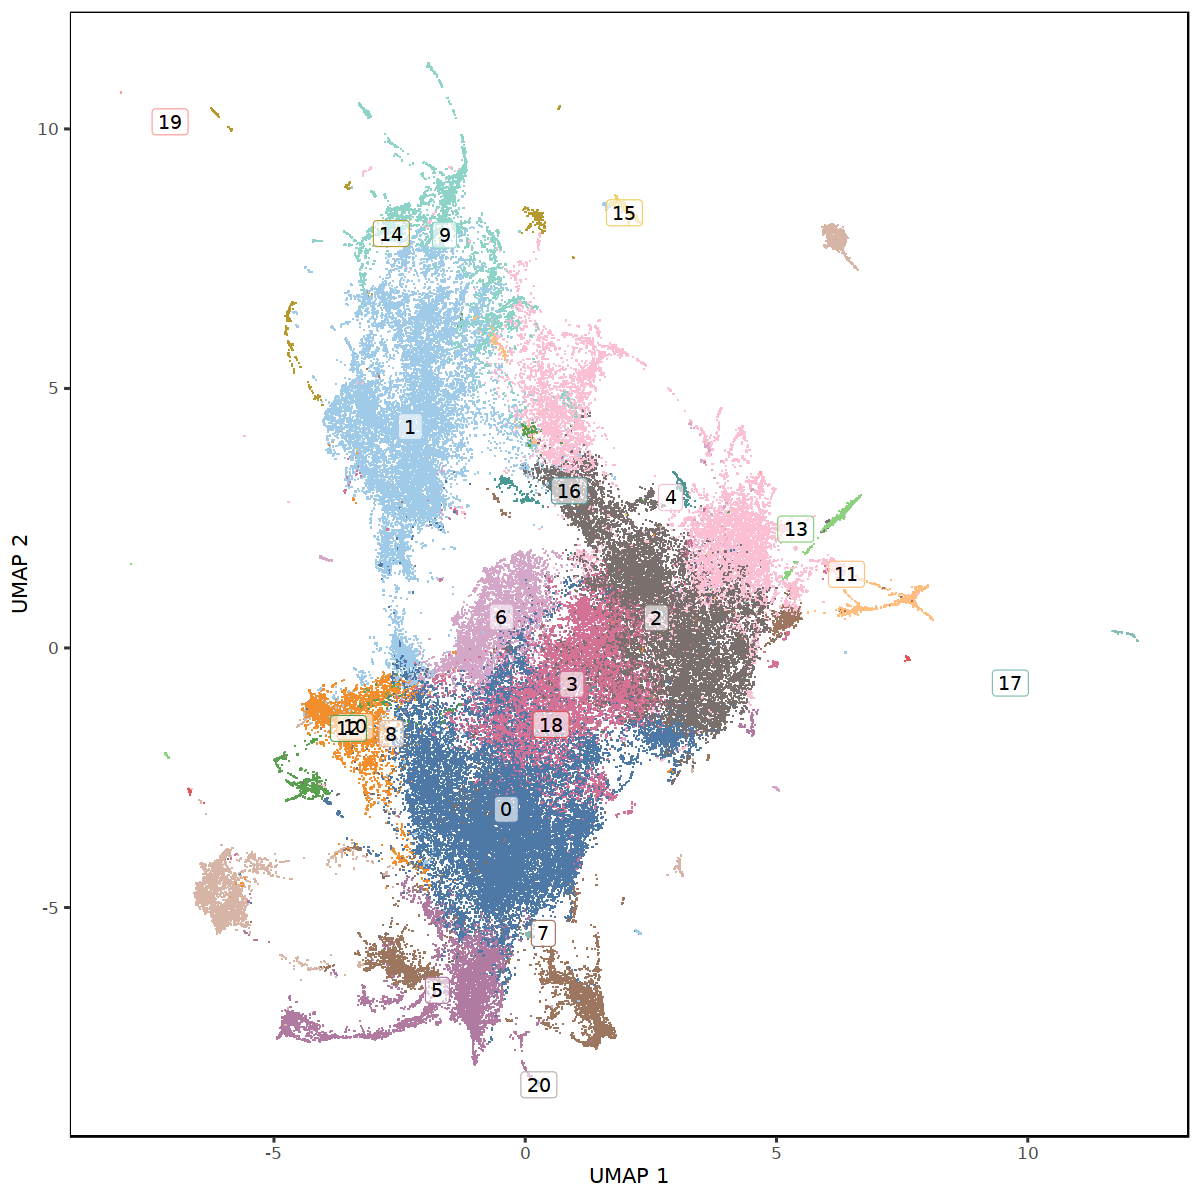

In [5]:
fig.size(10, 10)
with(spots, do_scatter(U1$embedding, Clusters, 'Clust0.4'))


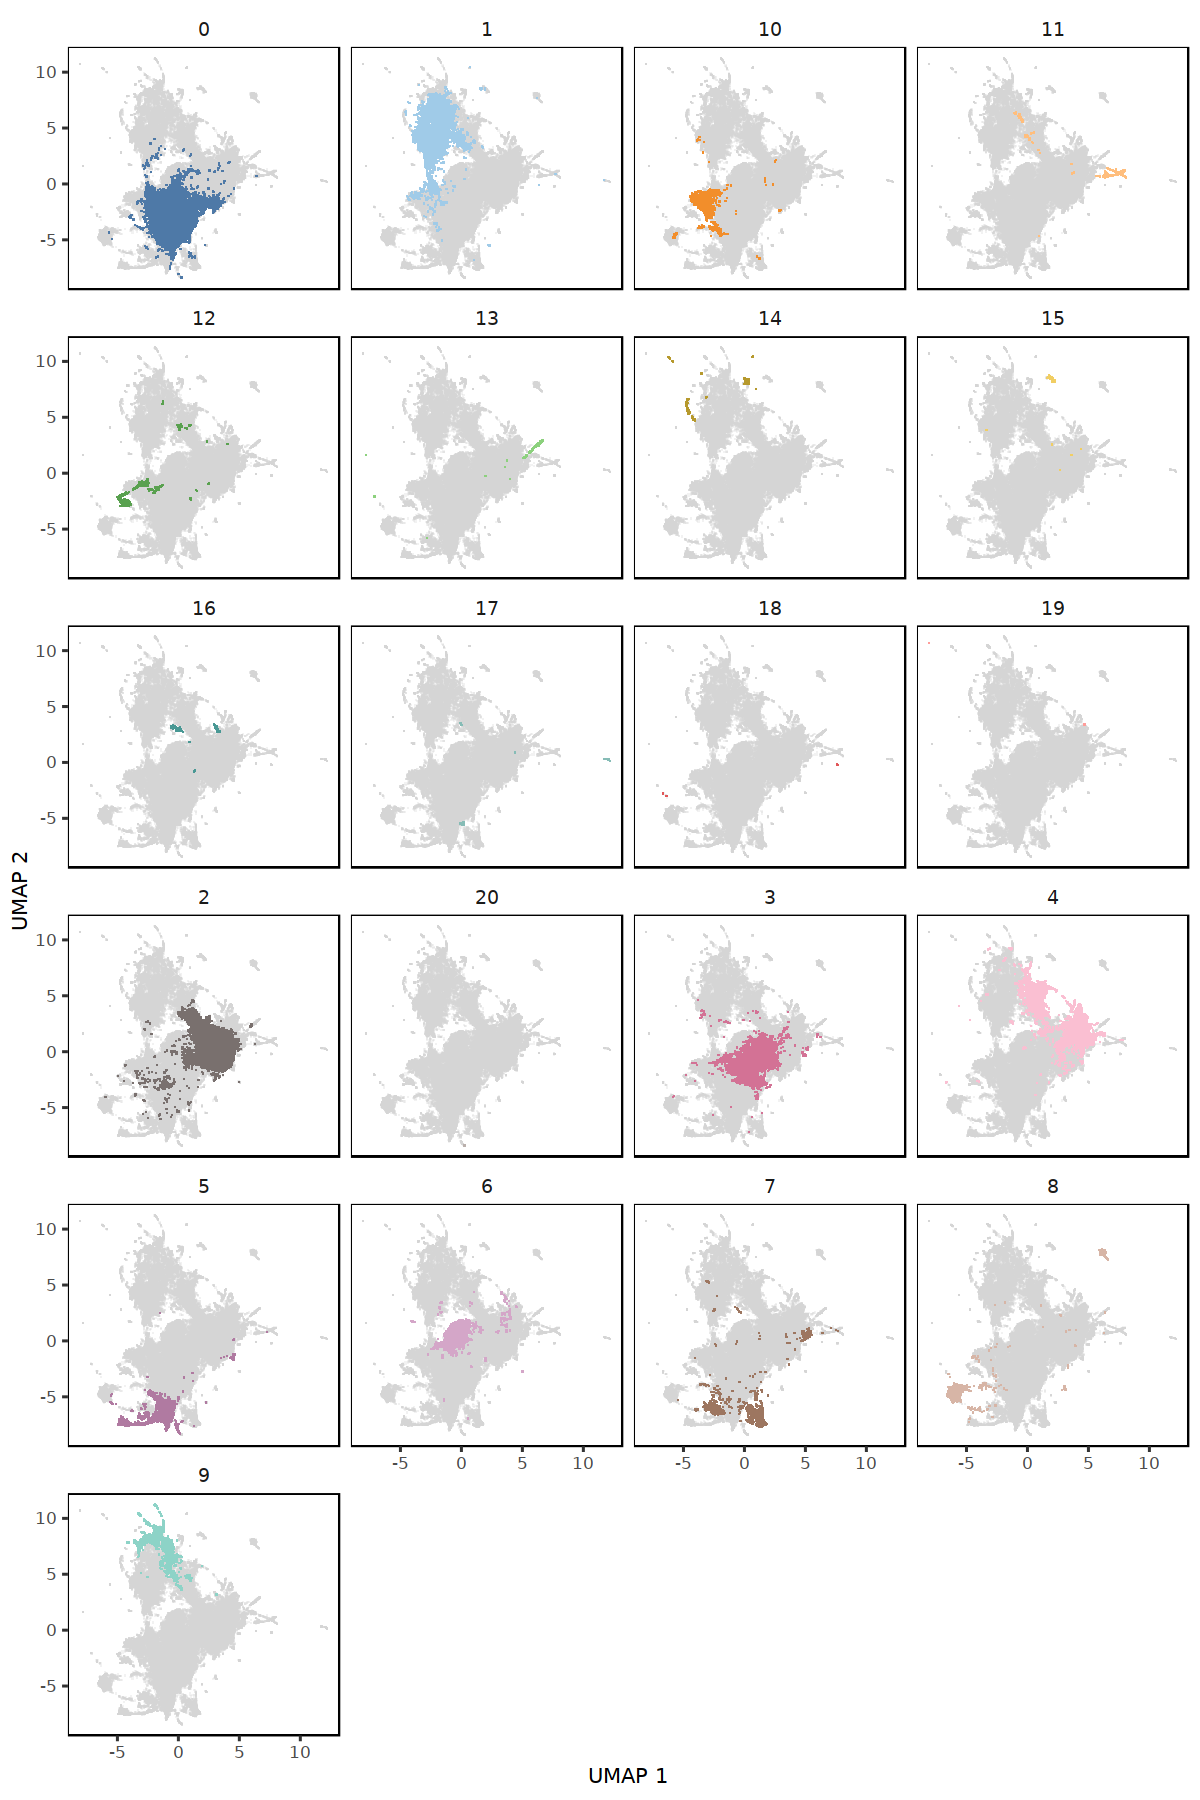

In [6]:
fig.size(15, 10)
with(spots, {
    do_scatter(U1$embedding, Clusters, 'Clust0.4', quo(`Clust0.4`), do_labels=FALSE, nrow=6)       
})


## Plot markers (UMAP)

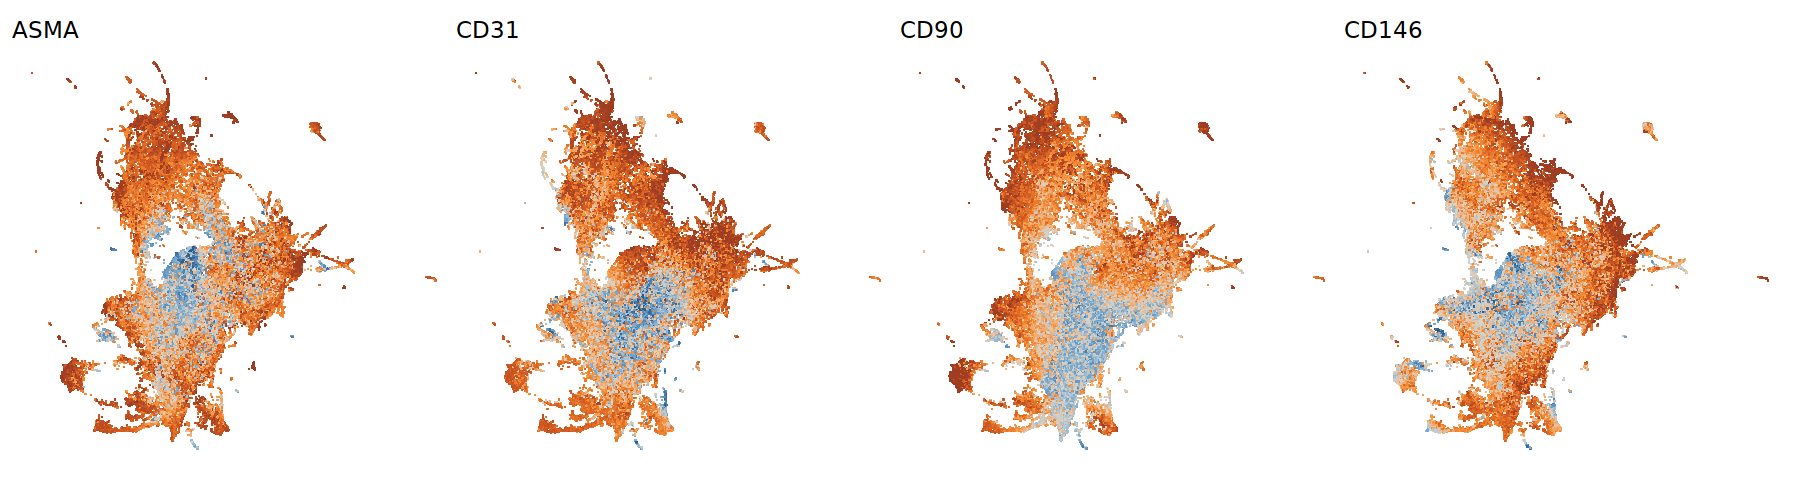

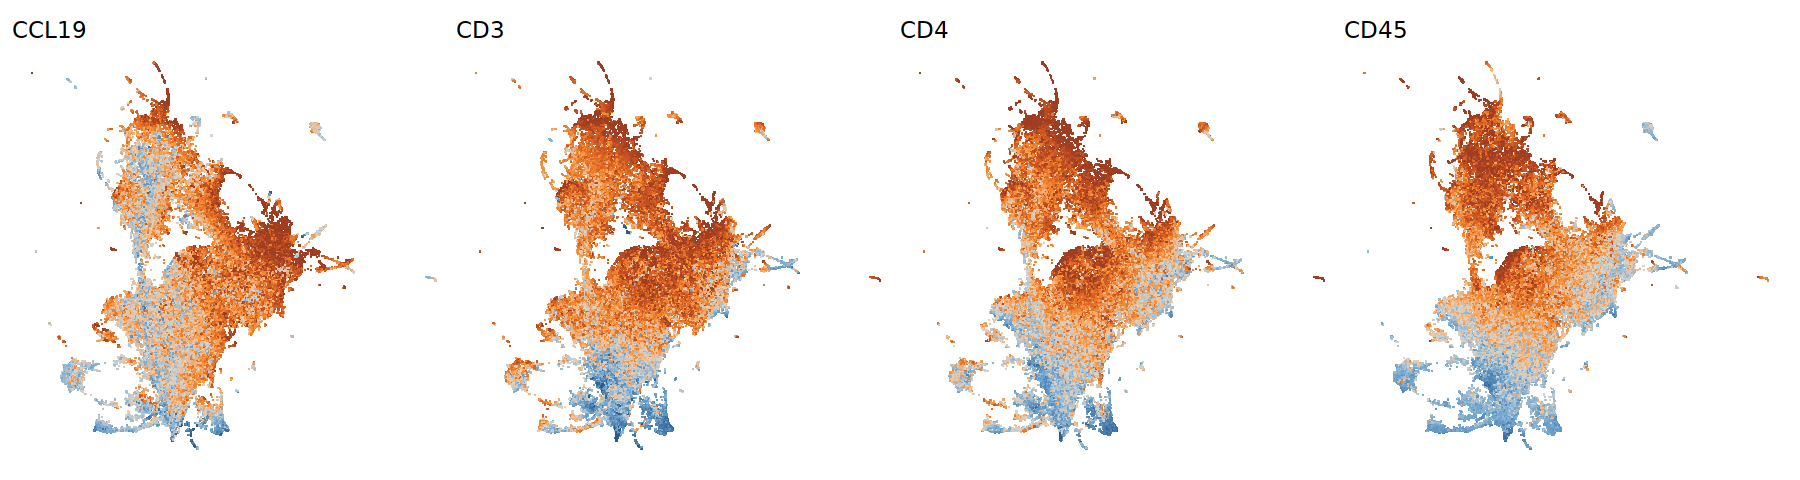

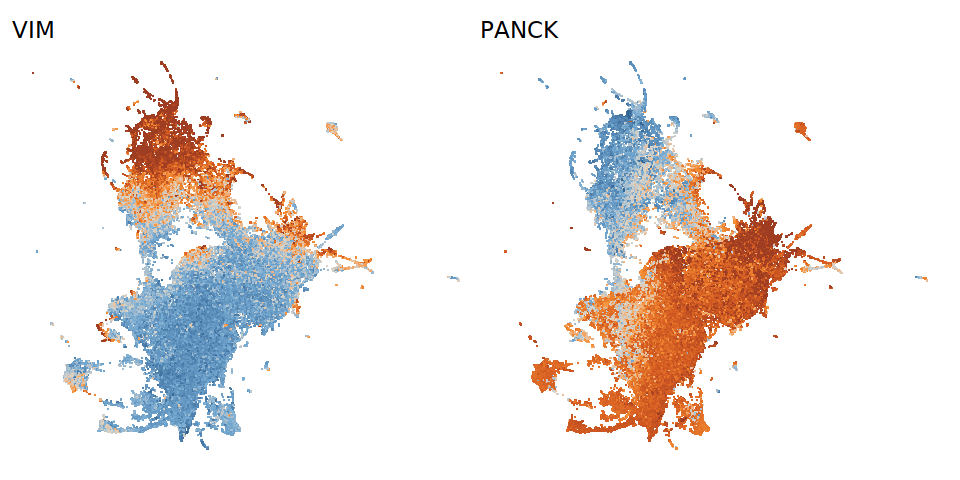

In [7]:
fig.size(4, 15)
plotFeatures(t(spots$z), spots$U1$embedding, c('ASMA', 'CD31', 'CD90', 'CD146'), nrow = 1,no_guide = TRUE, empty_theme = TRUE) %>% plot()
plotFeatures(t(spots$z), spots$U1$embedding, c('CCL19', 'CD3', 'CD4', 'CD45'), nrow = 1,no_guide = TRUE, empty_theme = TRUE) %>% plot() 

fig.size(4, 8)
plotFeatures(t(spots$z), spots$U1$embedding, c('VIM', 'PANCK'), nrow = 1, no_guide = TRUE, empty_theme = TRUE) %>% plot() 



## Plot markers (heatmap)

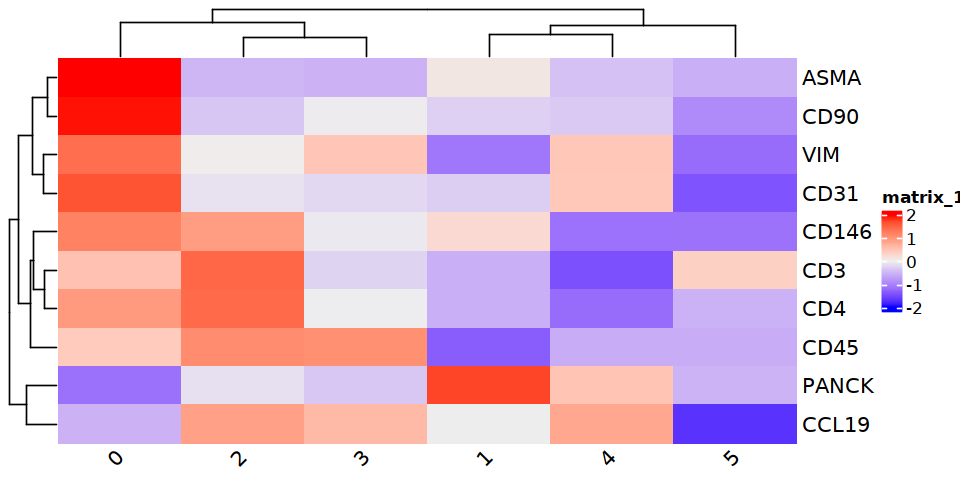

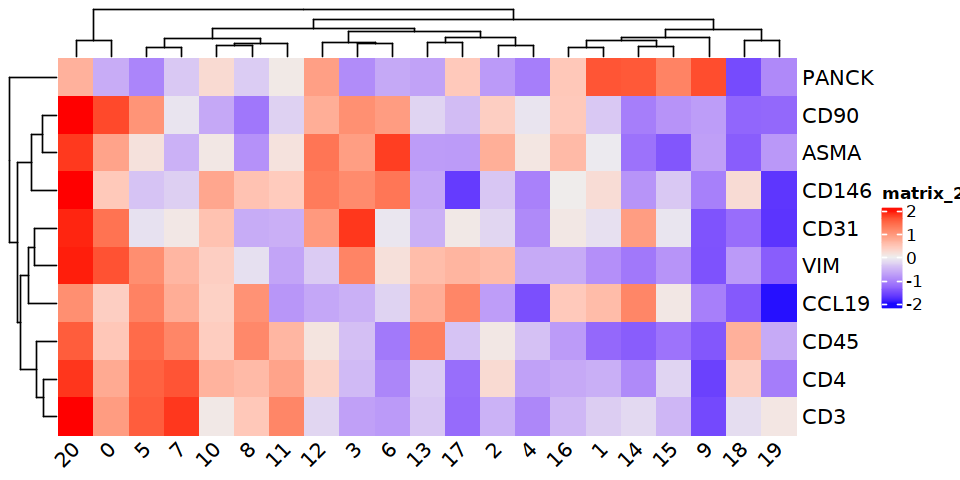

In [8]:
fig.size(4, 8)
plot_heatmap(spots$Markers$`Clust0.1`, c('ASMA', 'CD31', 'CD90', 'CD146', 'CCL19', 'CD3', 'CD4', 'CD45', 'VIM', 'PANCK'), TRUE)
plot_heatmap(spots$Markers$`Clust0.4`, c('ASMA', 'CD31', 'CD90', 'CD146', 'CCL19', 'CD3', 'CD4', 'CD45', 'VIM', 'PANCK'), TRUE)

## Label 

In [9]:
if ('Niche' %in% colnames(spots$metadata)) 
    spots$metadata$Niche <- NULL

spots$metadata$Cluster <- paste0('C', spots$Clusters$`Clust0.4`)

spots$metadata <- spots$metadata %>% 
    dplyr::mutate(Niche = case_when(
        Cluster %in% paste0('C', c(5)) ~ 'Lymphoid1',
        Cluster %in% paste0('C', c(7)) ~ 'Lymphoid2',
        Cluster %in% paste0('C', c(11)) ~ 'Lymphoid3',
        Cluster %in% paste0('C', c(13, 18)) ~ 'Lymphoid4',
        Cluster %in% paste0('C', c(12)) ~ 'Perivascular1',
        Cluster %in% paste0('C', c(3)) ~ 'Perivascular2',
        Cluster %in% paste0('C', c(6)) ~ 'Perivascular3',
        # Cluster %in% paste0('C', c()) ~ 'Perivascular4',
        Cluster %in% paste0('C', c(0)) ~ 'Lympho_Vascular1',
        Cluster %in% paste0('C', c(10)) ~ 'Lympho_Vascular2',
        Cluster %in% paste0('C', c(2)) ~ 'Lympho_Vascular3',
        Cluster %in% paste0('C', c(20)) ~ 'Lympho_Vascular3',
        # Cluster %in% paste0('C', c()) ~ 'Lympho_Vascular_Epithelial',
        Cluster %in% paste0('C', c(1, 14, 15, 9)) ~ 'Epithelial',
        TRUE ~ 'Other'
    )) %>% 
    dplyr::mutate(Niche_Broad = gsub('\\d+', '', Niche))

## Viz Labels (UMAP)

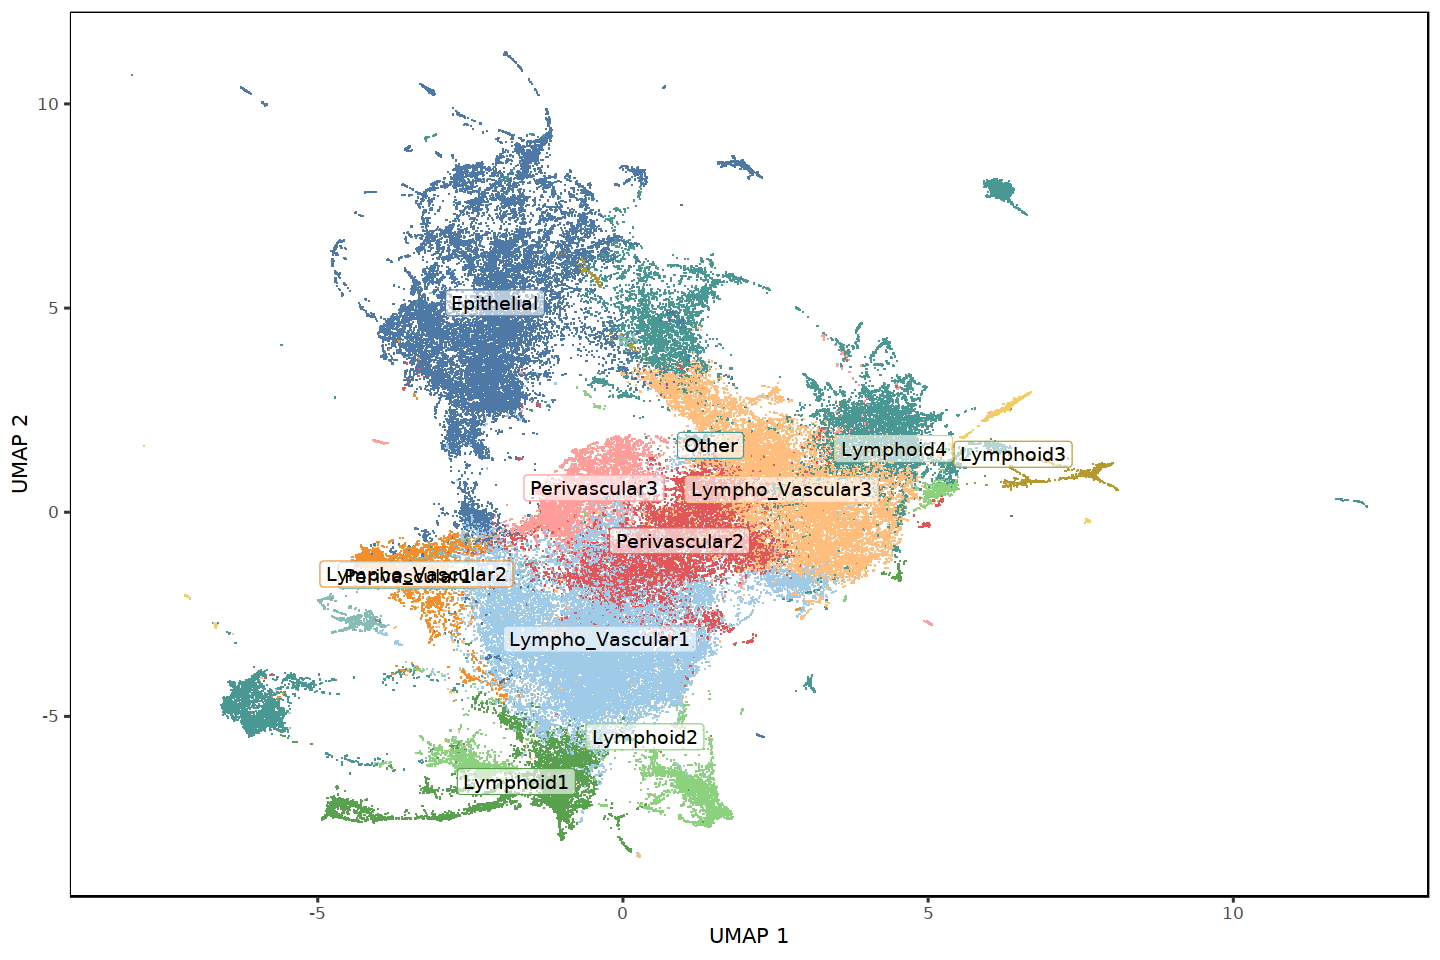

In [10]:
fig.size(8, 12)
with(spots, {
    do_scatter(U1$embedding, metadata, 'Niche', do_labels = TRUE)    
})


## Viz Labels (Physical)

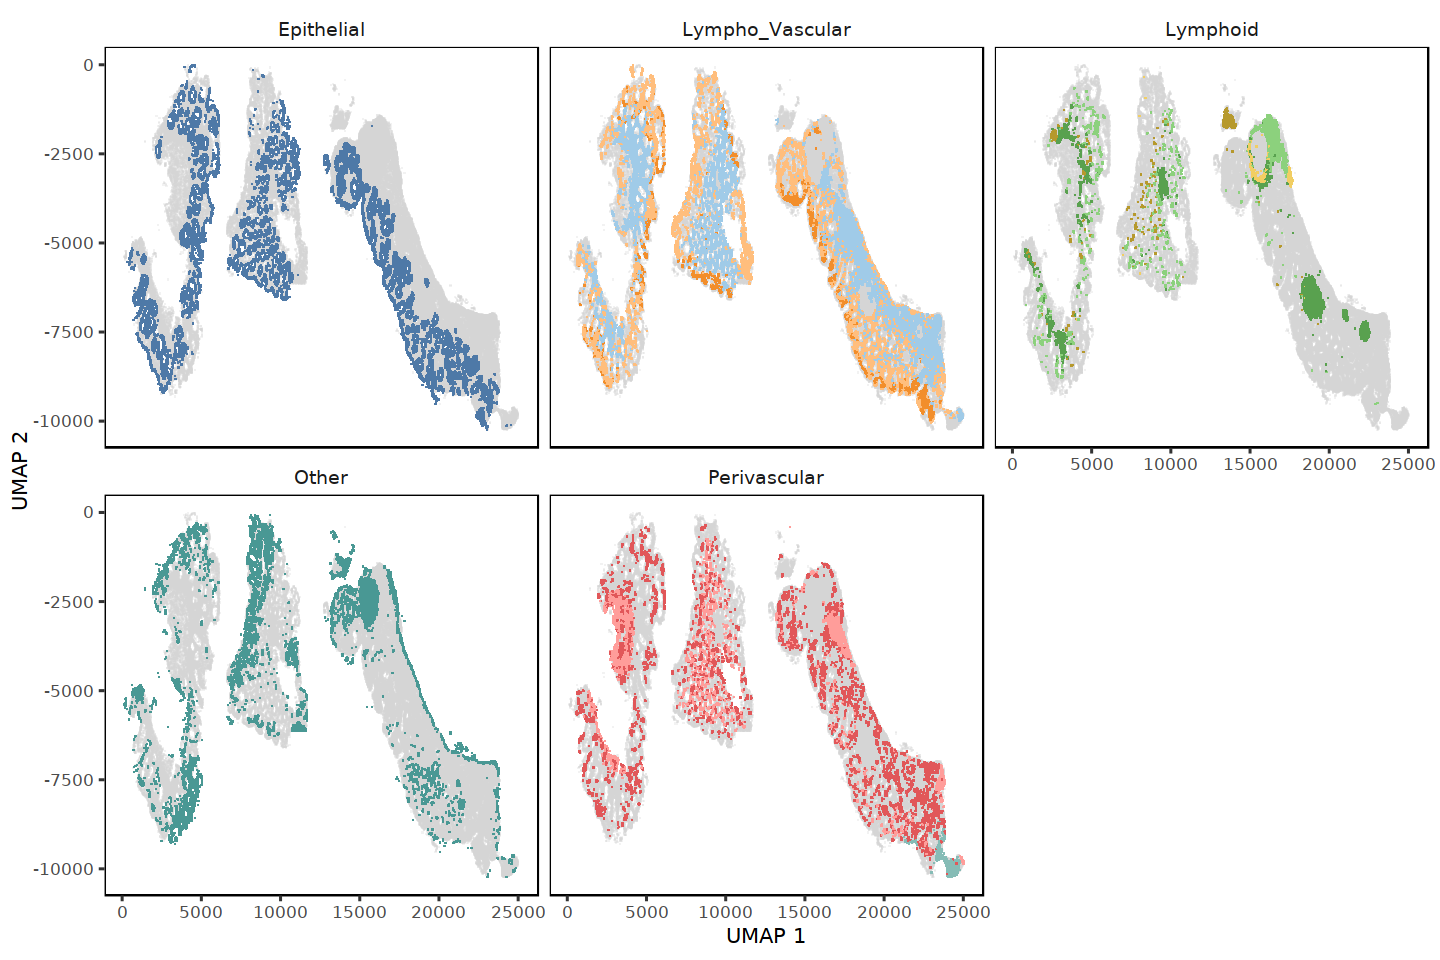

In [11]:
fig.size(8, 12)
with(spots, {
    do_scatter(
        data.frame(x = metadata$y, y = -metadata$x),
        metadata, 
        'Niche', quo(Niche_Broad), 
        do_labels = FALSE, 
        nrow = 2
    )    
})


## Niche heatmap

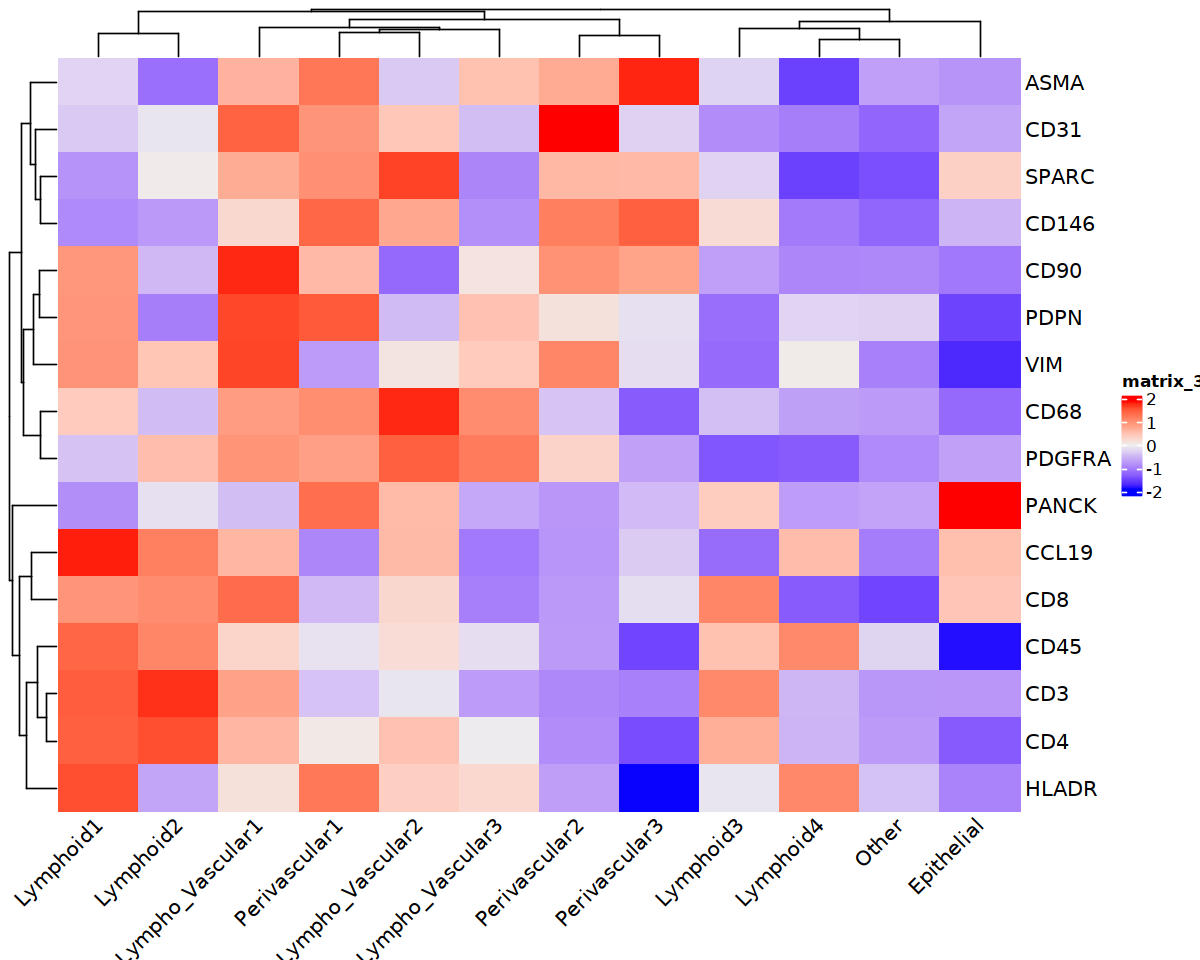

In [12]:
fig.size(8, 10)
with(spots, wilcoxauc(t(z), metadata$Niche)) %>% 
    plot_heatmap(.scale=TRUE)

## Cache

In [13]:
saveRDS(spots, glue('{datadir}/gut_spots.rds'))

# Fibroblast fine-grained

In [14]:
cells <- readRDS(glue('{datadir}/gut_cells.rds'))


## Visualize cell clusters

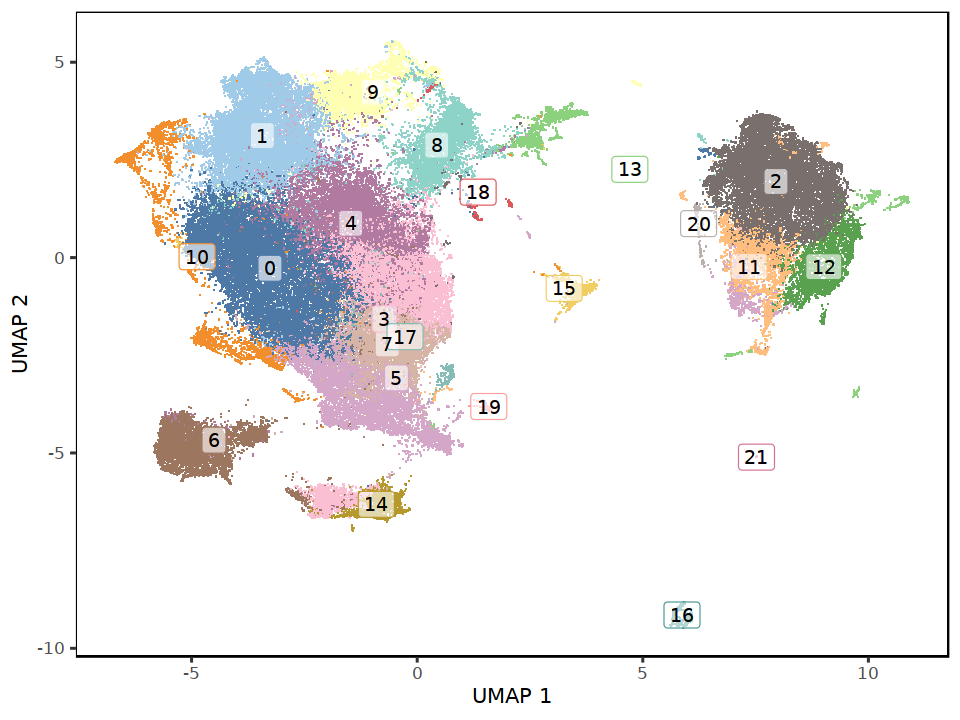

In [15]:
fig.size(6, 8)
with(cells, do_scatter(U1$embedding, Clusters, 'Clust0.8'))


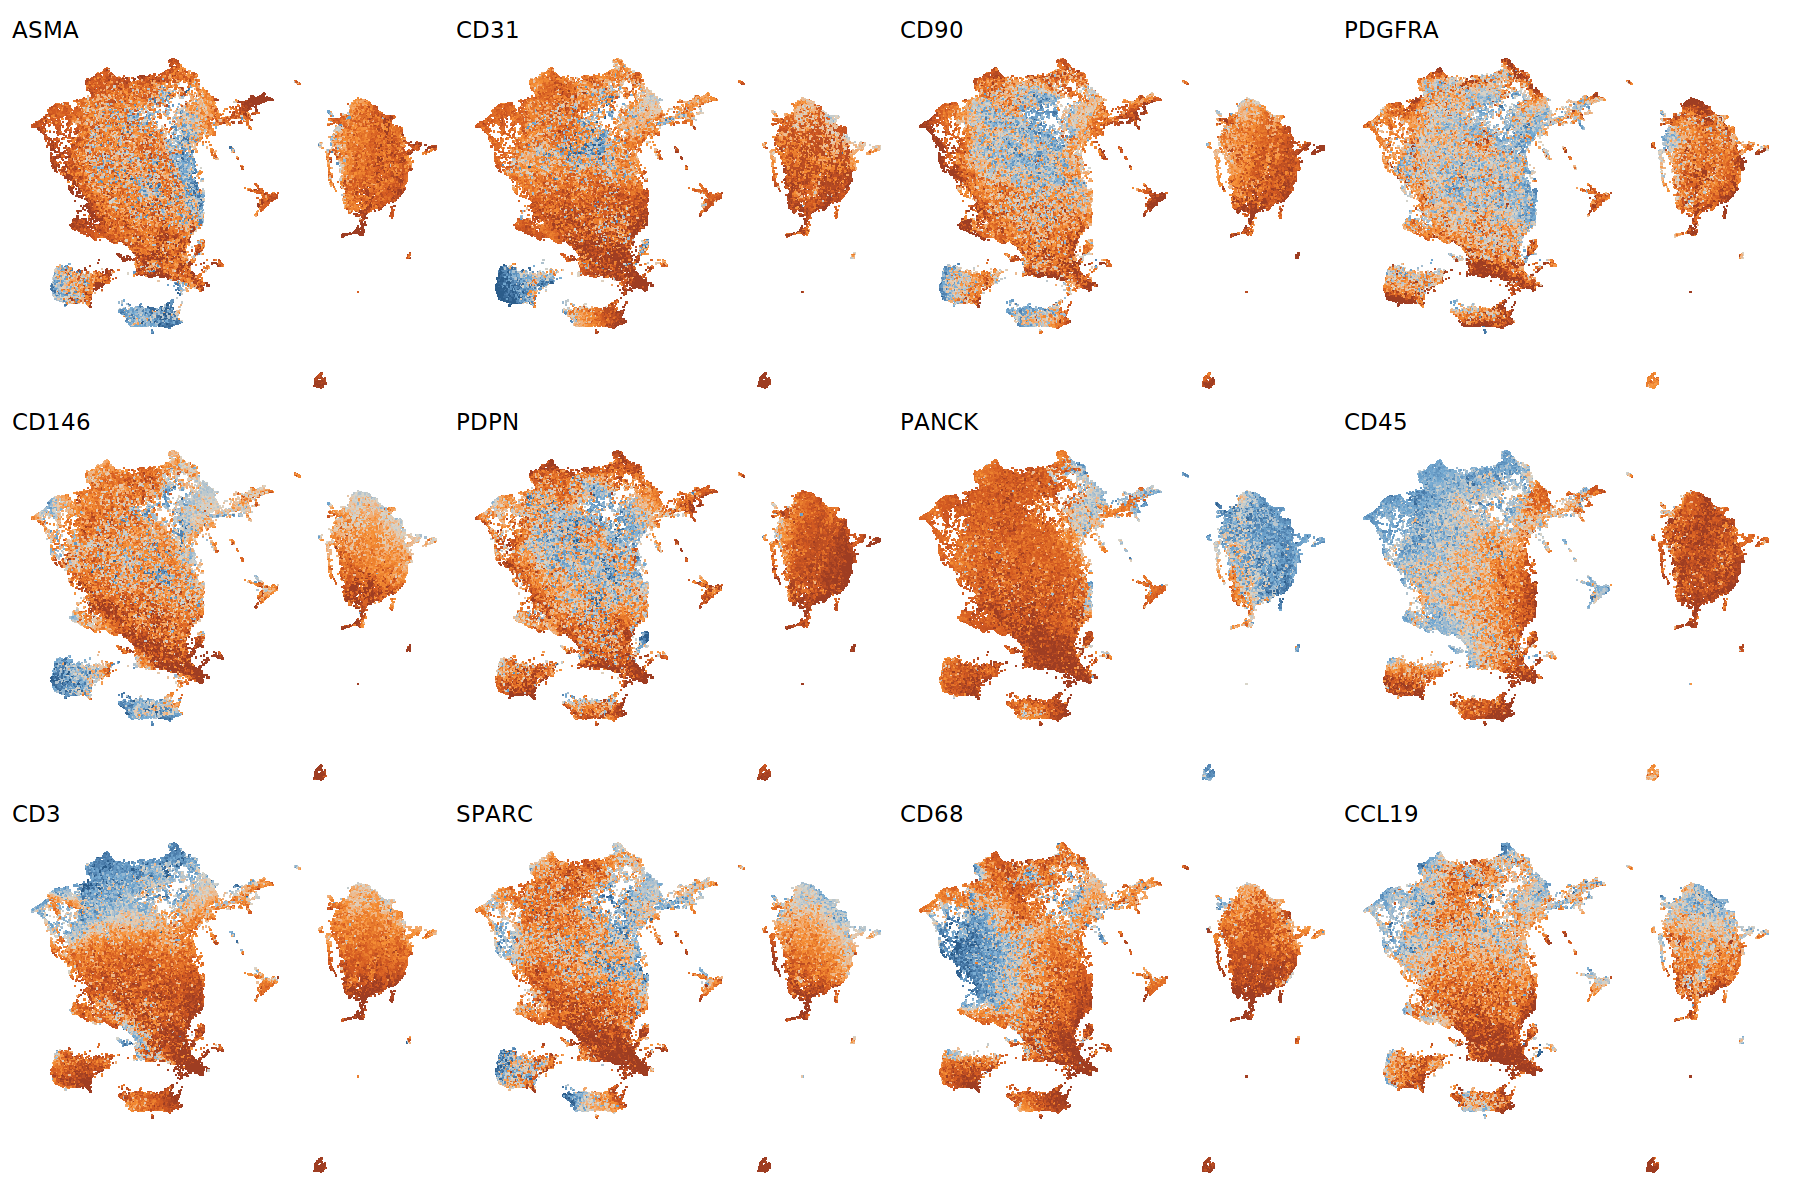

In [16]:
fig.size(10, 15)
with(cells, {
    plotFeatures(t(z), U1$embedding, c('ASMA', 'CD31', 'CD90', 'PDGFRA', 'CD146', 'PDPN', 'PANCK', 'CD45', 'CD3', 'SPARC', 'CD68', 'CCL19'), nrow = 3, no_guide = TRUE, empty_theme = TRUE) %>% plot()
})


In [17]:
spots <- readRDS(glue('{datadir}/gut_spots.rds'))
cells$metadata$Niche <- NULL
cells$metadata$Niche <- cells$metadata %>% 
    left_join(
        dplyr::select(spots$metadata, SpotID, Niche), 
        by = c('CellID' = 'SpotID')
    ) %>% 
    with(Niche)


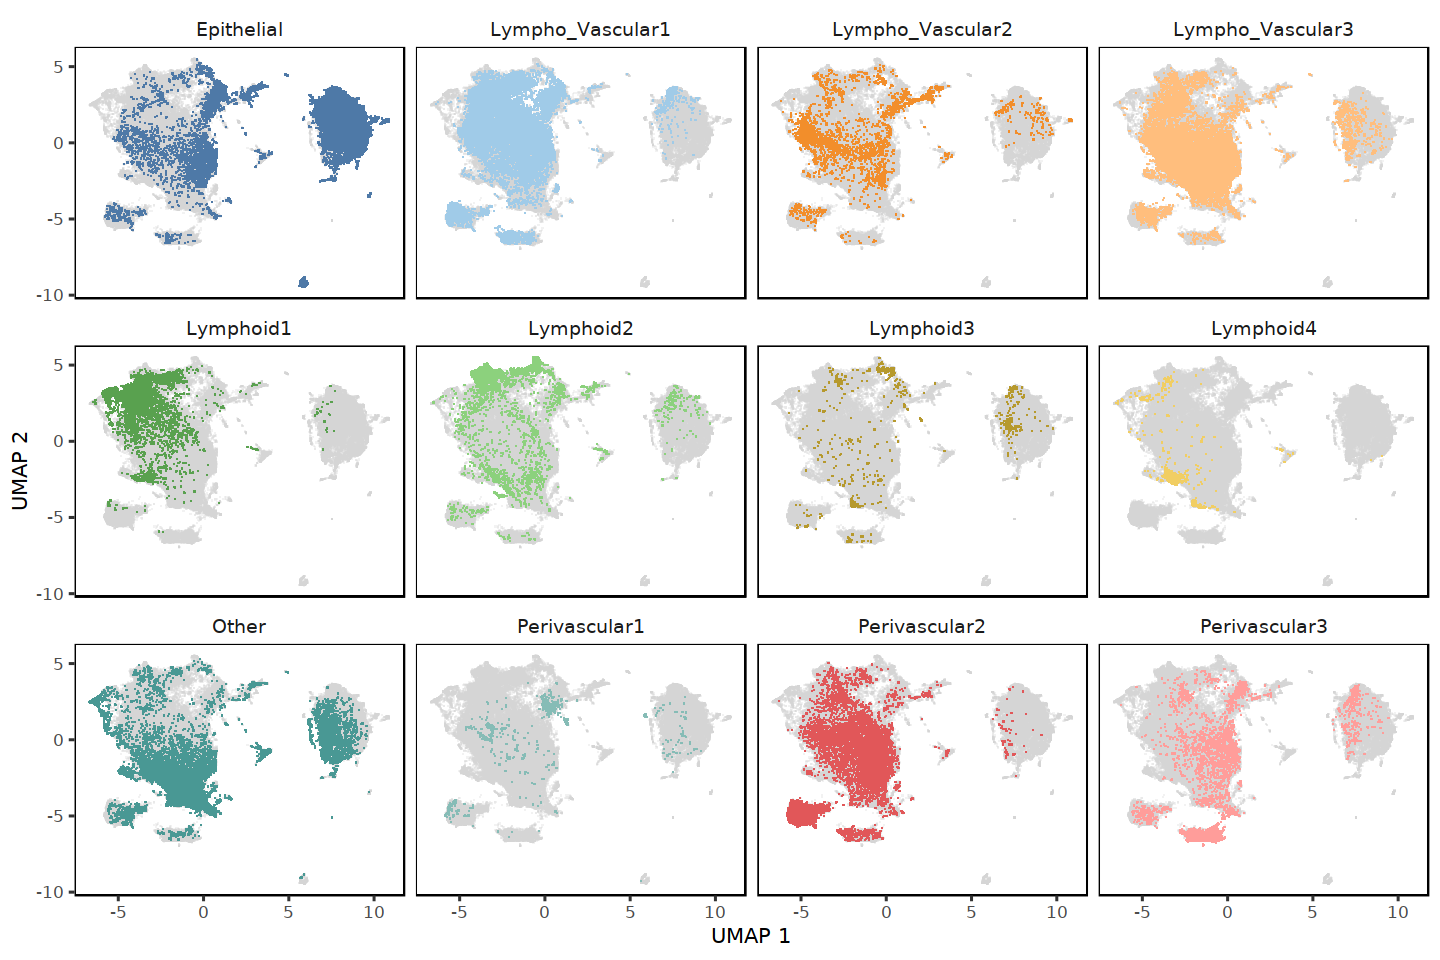

In [18]:
fig.size(8, 12)
with(cells, do_scatter(U1$embedding, metadata, 'Niche', quo(Niche), nrow=3, do_labels = FALSE))


## Isolate fibroblasts

Picking joint bandwidth of 0.11



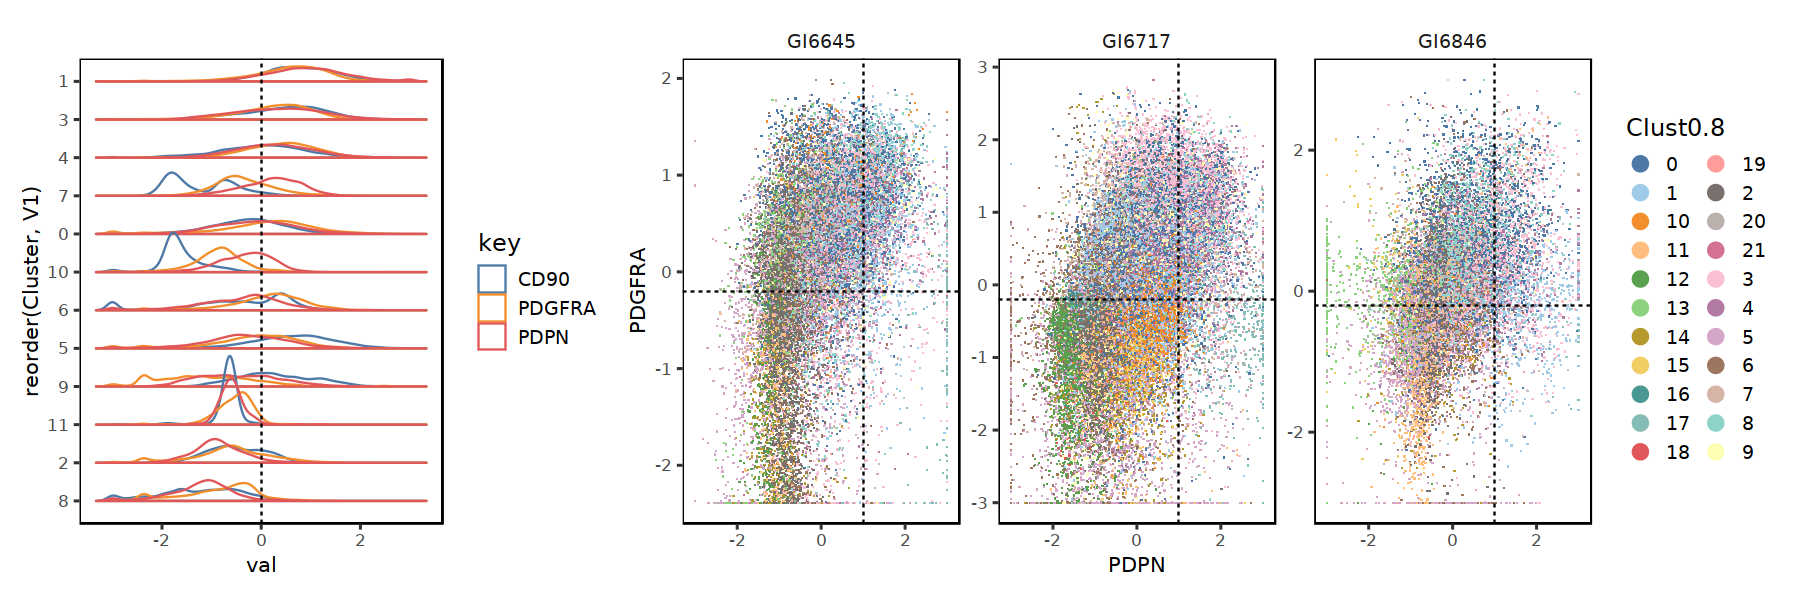

In [19]:
fig.size(5, 15)
p1 <- data.table(cbind(cells$metadata, cells$z, Cluster=cells$Clusters$`Clust0.4`))[
    , V1 := median(PDPN), by = Cluster
] %>% 
    tidyr::gather(key, val, PDPN, PDGFRA, CD90) %>% 
    ggplot(aes(val, reorder(Cluster, V1), color = key)) + 
    # ggplot(aes(PDPN + PDGFRA, reorder(Cluster, V1))) + 
        geom_density_ridges2(fill = NA) + 
        scale_color_tableau() + 
        geom_vline(xintercept = c(0), linetype = 2) + 
        NULL 

p2 <- cells$z %>% 
    data.frame() %>% 
    dplyr::select(PDPN, PDGFRA) %>% 
    do_scatter(cbind(cells$Clusters, cells$metadata), 'Clust0.8', do_labels = FALSE, no_guides = FALSE) + 
        labs(x = 'PDPN', y = 'PDGFRA') + 
        facet_wrap(~LibraryID, scales = 'free') + 
        geom_vline(xintercept = 1, linetype = 2) + 
        geom_hline(yintercept = -.2, linetype = 2) + 
        NULL

(p1 | p2) + plot_layout(widths = c(1, 2.5))


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




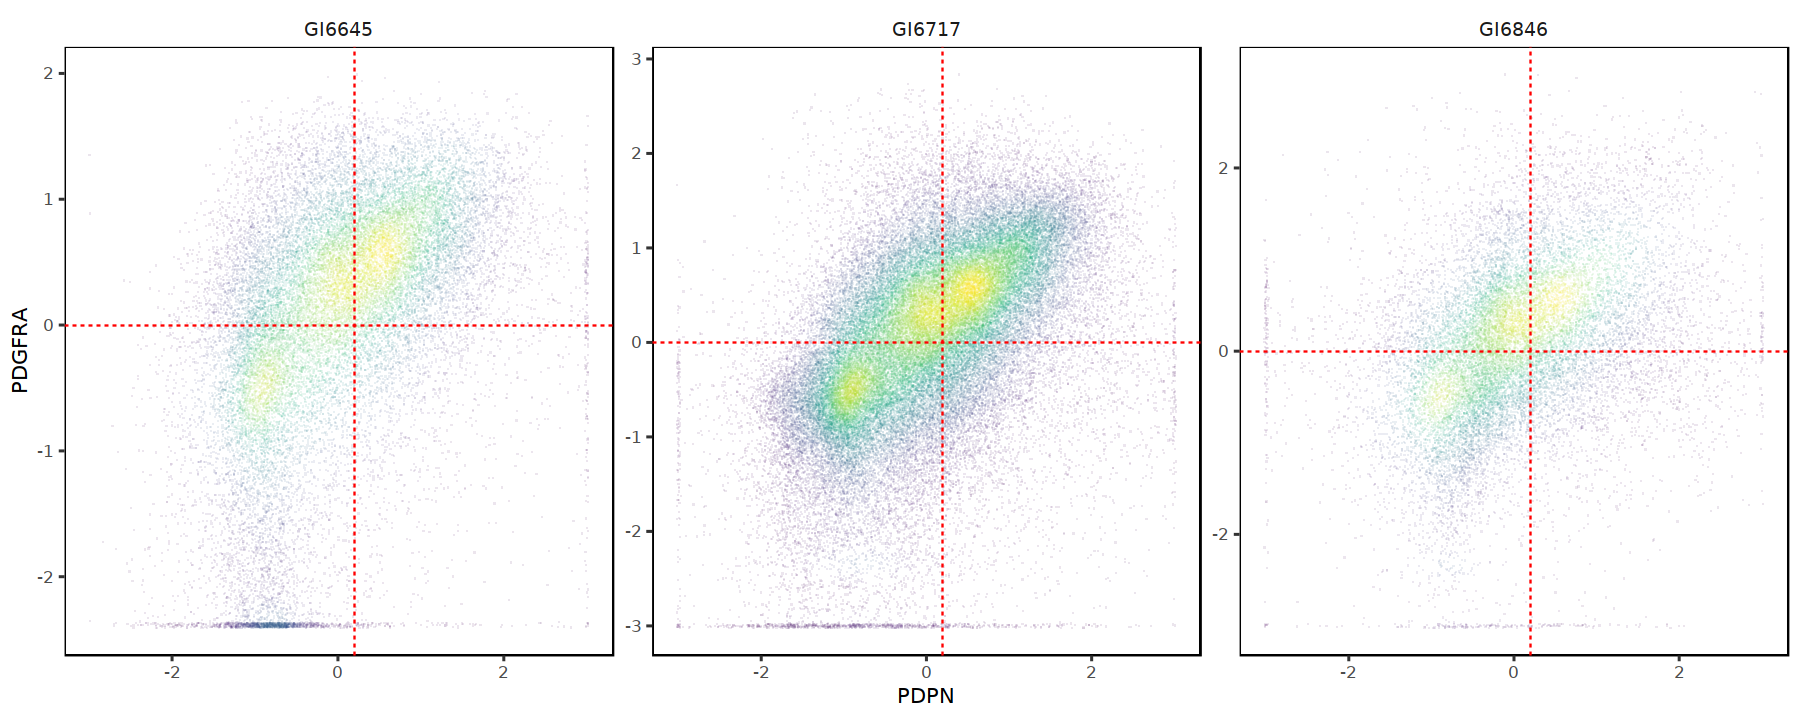

In [20]:
fig.size(6, 15)
plot_biaxial(cells$z, 'PDPN', 'PDGFRA', 0.2, 0, cells$metadata$LibraryID)

In [21]:
fibroblast_clusters <- cells$Markers$`Clust0.4` %>% 
    subset(
        (feature %in% c('PDPN') & auc > .6) | 
        (feature %in% c('PDGFRA') & auc > .6)
    ) %>% 
    with(unique(group))

message('Fibroblast clusters:')
fibroblast_clusters

idx <- cbind(Cluster = cells$Clusters$`Clust0.4`, cells$z) %>% 
    data.frame() %>% 
    tibble::rowid_to_column('id') %>% 
    subset(Cluster %in% fibroblast_clusters) %>% 
    subset(PDPN > .2 | PDGFRA > 0) %>% 
    with(id)

message('Number of fibroblasts:')
length(idx)

Fibroblast clusters:



[1] "1" "3" "4"

Number of fibroblasts:



[1] 36681

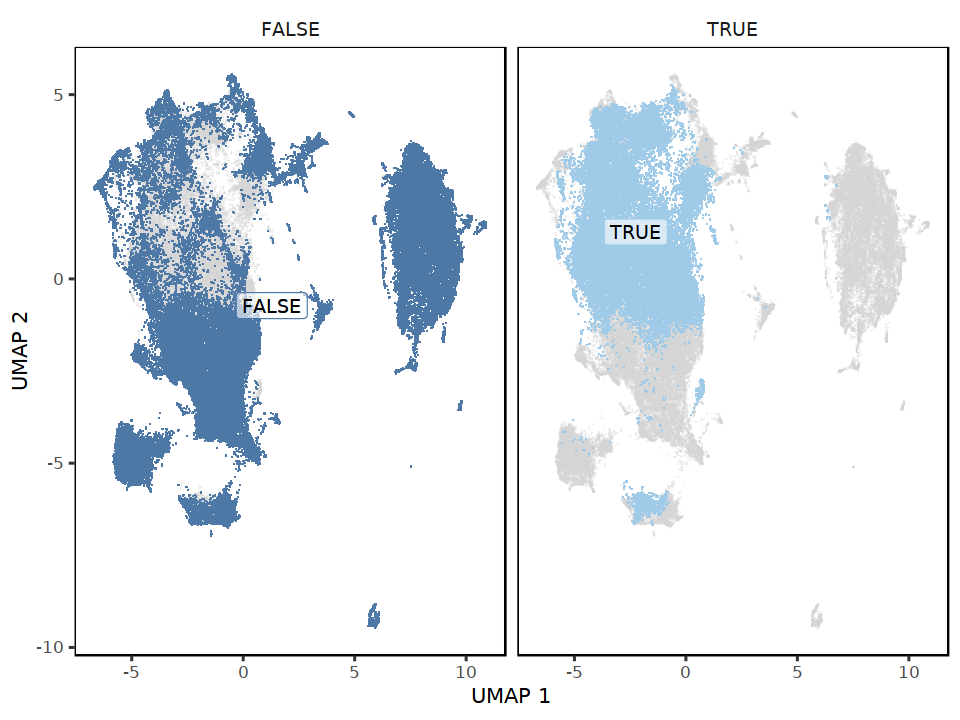

In [22]:
fig.size(6, 8)
with(cells, do_scatter(
    U1$embedding, 
    tibble(val = seq_len(nrow(cells$metadata)) %in% idx), 
    'val', 
    quo(val)
))


In [23]:
fibroblasts <- list(
    metadata = cells$metadata[idx, ], 
    intensity = cells$intensity[idx, ],
    Clusters = cells$Clusters[idx, ]
)


## PCA etc. 

UMAP

UMAP

PCA

SCALE

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36681
Number of edges: 387735

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8151
Number of communities: 9
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36681
Number of edges: 387735

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7695
Number of communities: 14
Elapsed time: 12 seconds


New names:
* NA -> ...1
* NA -> ...2



   user  system elapsed 
307.387 123.653 266.410 

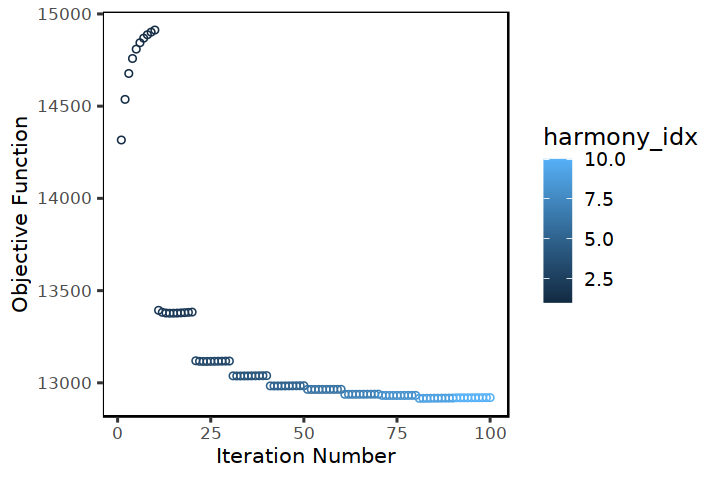

In [24]:
system.time({
     fibroblasts <- fibroblasts %>% 
        do_norm() %>% 
        do_scale(3, TRUE) %>% 
        do_pca() %>% 
        do_umap('V', 'U0') %>% 
        harmonize(theta=1) %>% 
        do_umap('H', 'U1') %>% 
        do_louvain('U1', c(.4, .8)) %>% 
        do_markers() %>% 
        identity()
})


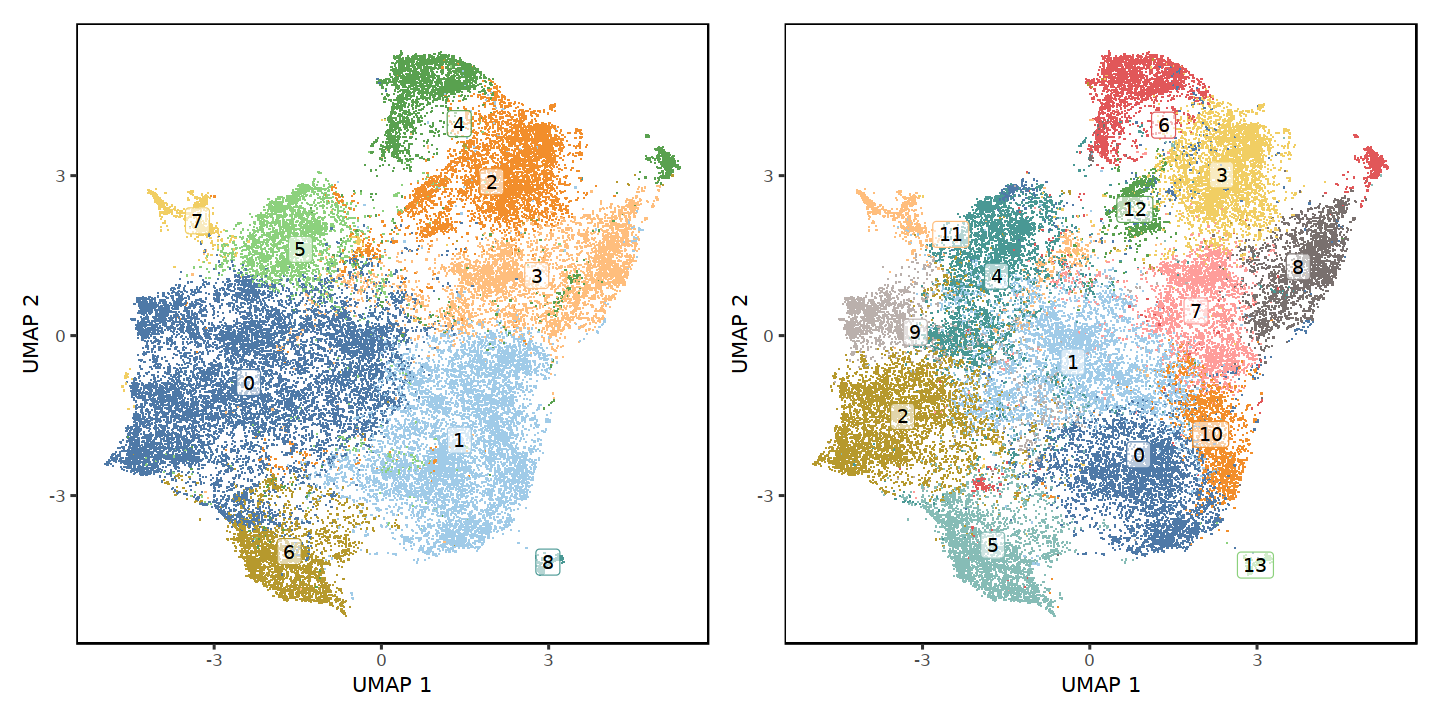

In [25]:
fig.size(6, 12)
with(fibroblasts, do_scatter(U1$embedding, Clusters, 'Clust0.4')) | 
with(fibroblasts, do_scatter(U1$embedding, Clusters, 'Clust0.8'))


## Viz markers

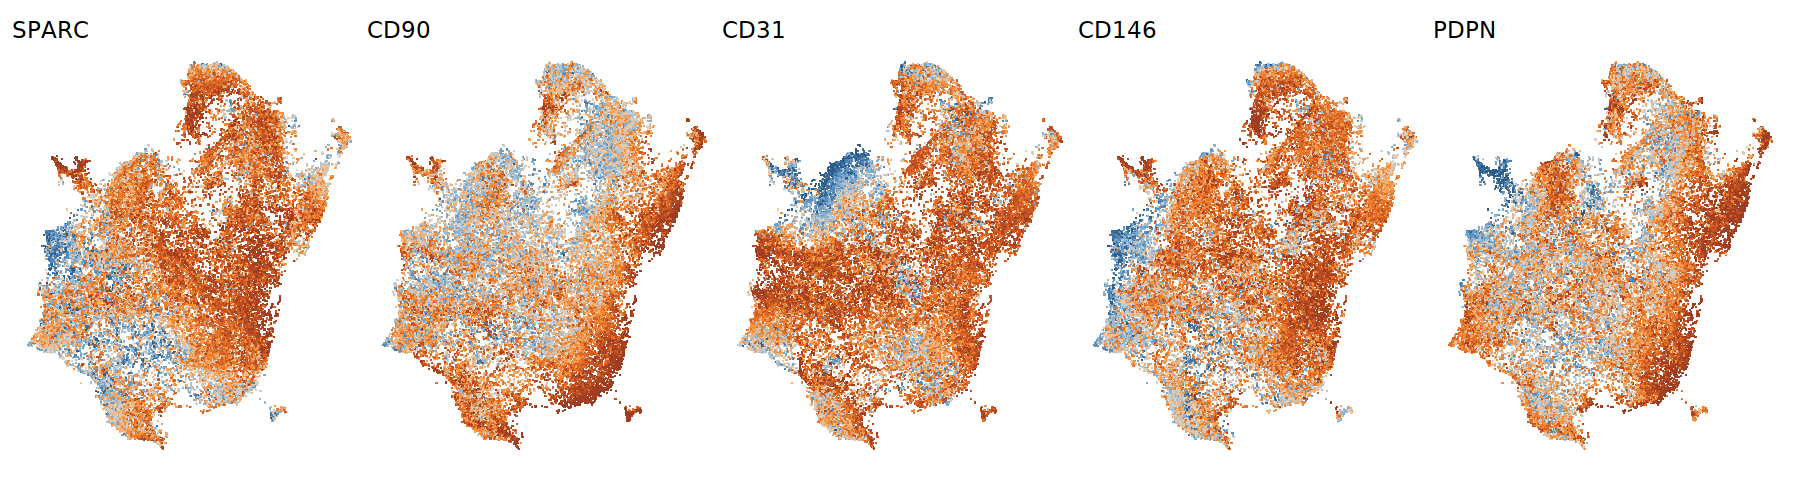

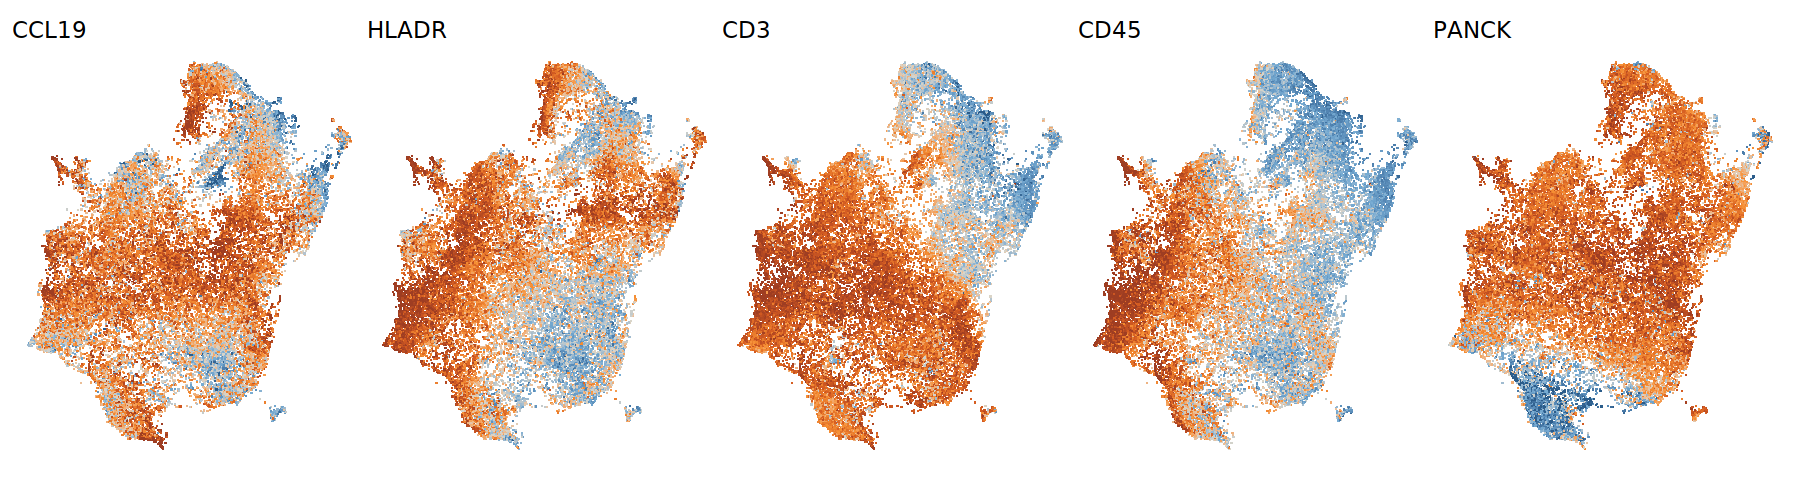

In [26]:
fig.size(4, 15)
with(fibroblasts, {
    plotFeatures(t(z), U1$embedding, c('SPARC', 'CD90', 'CD31', 'CD146', 'PDPN'), nrow = 1, no_guide = TRUE, empty_theme = TRUE) %>% plot()
    plotFeatures(t(z), U1$embedding, c('CCL19', 'HLADR', 'CD3', 'CD45', 'PANCK'), nrow = 1, no_guide = TRUE, empty_theme = TRUE) %>% plot()
    # plotFeatures(t(z), U1$embedding, c('CD3', 'CCL19', 'HLADR', 'CD90', 'SPARC', 'PDPN', 'CD68', 'CD31'), nrow = 2, no_guide = TRUE, empty_theme = TRUE) %>% plot()
})



In [27]:
# plot_heatmap(fibroblasts$Markers$`Clust0.4`, c('CCL19', 'PDPN', 'PDGFRA', 'SPARC', 'CD90'))

## Viz Niches

In [28]:
# spots <- readRDS(glue('{datadir}/gut_spots.rds'))
fibroblasts$metadata$Niche <- NULL
fibroblasts$metadata$Niche <- fibroblasts$metadata %>% 
    left_join(
        dplyr::select(spots$metadata, SpotID, Niche), 
        by = c('CellID' = 'SpotID')
    ) %>% 
    with(Niche)


In [29]:
table(fibroblasts$metadata$Niche)


      Epithelial Lympho_Vascular1 Lympho_Vascular2 Lympho_Vascular3 
            1422            15321             1597             6043 
       Lymphoid1        Lymphoid2        Lymphoid3        Lymphoid4 
            3842             2173              132               94 
           Other    Perivascular1    Perivascular2    Perivascular3 
            1193              615             2802             1447 

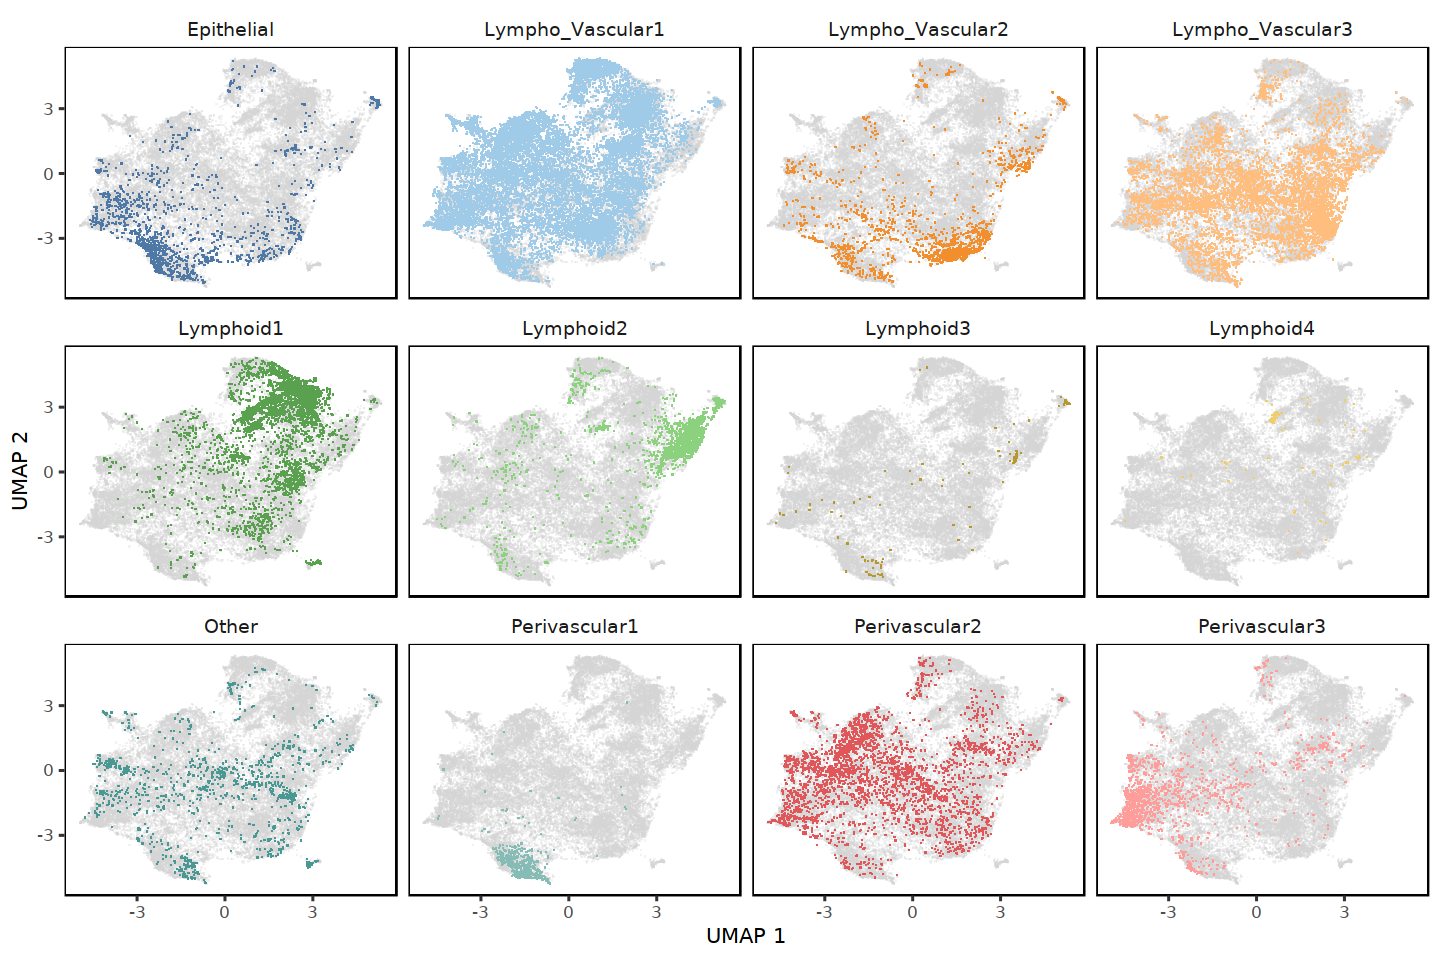

In [30]:
fig.size(8, 12)
with(fibroblasts, do_scatter(U1$embedding, metadata, 'Niche', quo(Niche), nrow=3, do_labels = FALSE))


## Label subtypes 

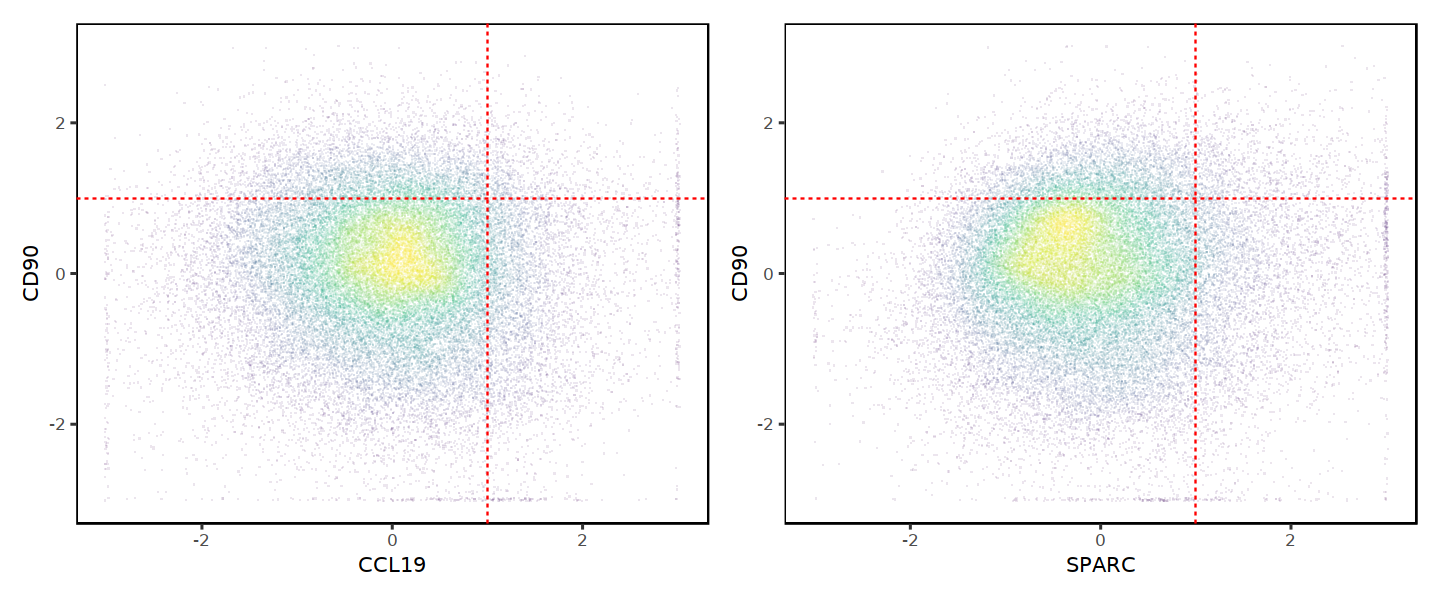

In [31]:
fig.size(5, 12)
plot_biaxial(fibroblasts$z, 'CCL19', 'CD90', 1, 1) | 
plot_biaxial(fibroblasts$z, 'SPARC', 'CD90', 1, 1) 


In [66]:
fibroblasts$metadata$Subtype <- data.frame(fibroblasts$z) %>% 
    cbind(fibroblasts$metadata) %>% 
    cbind(fibroblasts$Clusters) %>% 
    dplyr::mutate(Subtype = case_when(
        `Clust0.4` %in% c('2', '3', '4', '5') & CCL19 > 1 ~ 'Immuno',
        `Clust0.4` %in% c('0') & (SPARC > 0.5) ~ 'Vascular',
        TRUE ~ 'Fibroblast'
    )) %>% 
    with(Subtype)
table(fibroblasts$metadata$Subtype)



Fibroblast     Immuno   Vascular 
     28872       3011       4798 

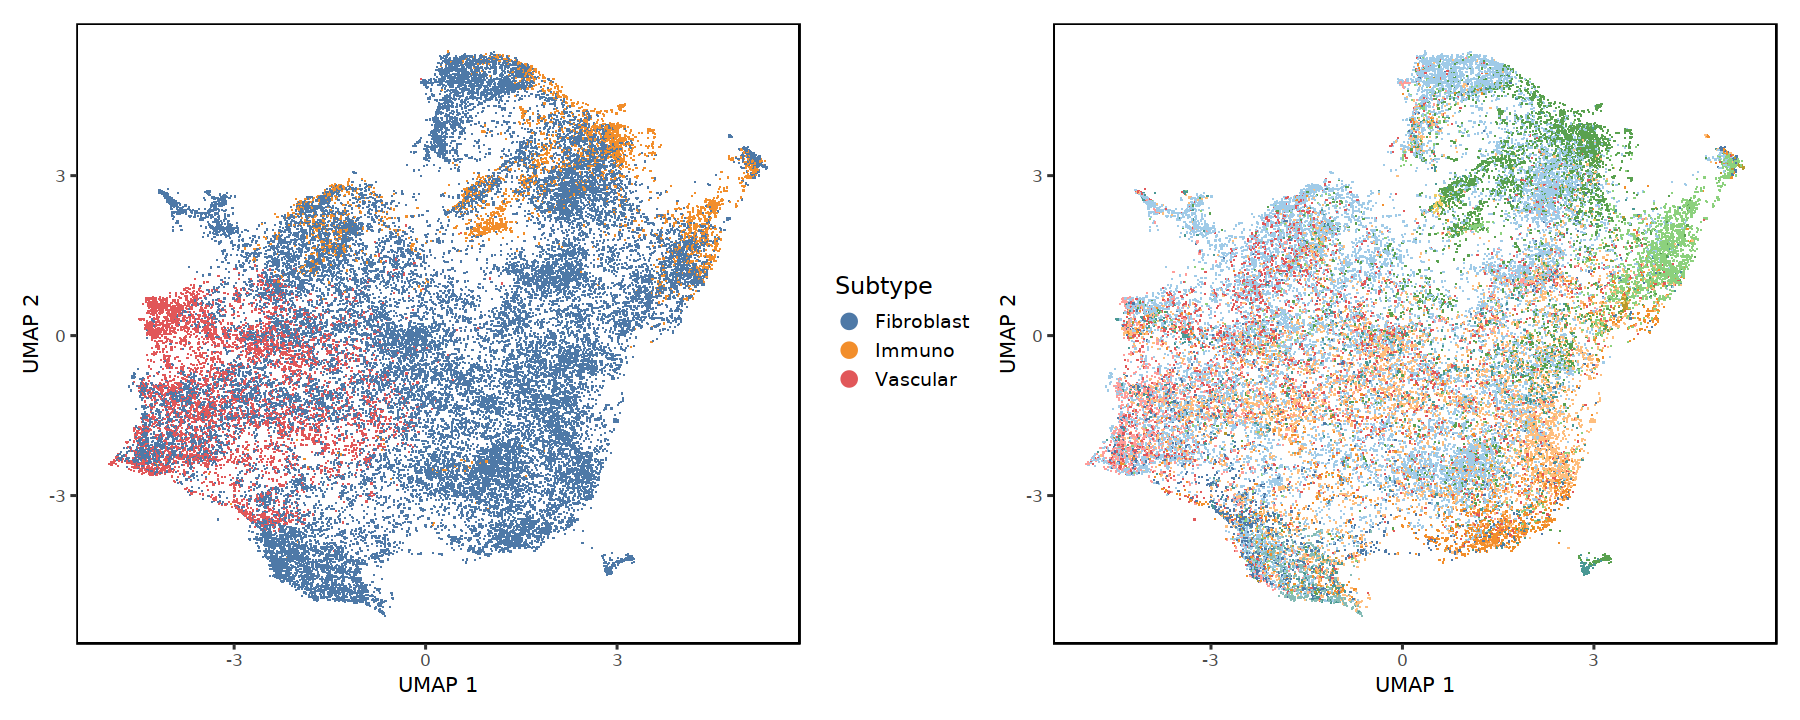

In [67]:
fig.size(6, 15)
with(fibroblasts, do_scatter(U1$embedding, metadata, 'Subtype', no_guides=FALSE, do_labels=FALSE, palette_use = tableau_color_pal()(3))) | 
with(fibroblasts, do_scatter(U1$embedding, metadata, 'Niche', do_labels = FALSE))




## Cache

In [68]:
saveRDS(fibroblasts, glue('{datadir}/gut_fibroblasts.rds'))

# Co-localization enrichment 

## Rename niches with nice names

In [94]:
spots <- readRDS(glue('{datadir}/gut_spots.rds'))
spots$metadata[['Niche_nice']] <- NULL
# spots$metadata[['Niche_nice']] <- spots$metadata$Niche
spots$metadata$Niche_nice <- spots$metadata %>% 
    dplyr::mutate(Niche_nice = case_when(
        Niche %in% c('Lymphoid2', 'Lymphoid1') ~ 'Lymphoid',
        Niche %in% c('Perivascular3') ~ 'Vascular_ASMA',
        Niche %in% c('Perivascular2') ~ 'Vascular',
        TRUE ~ 'Other'
    )) %>% 
    with(Niche_nice)

# <- spots$metadata %>% 
#     left_join(
#         tribble(
#             ~Niche, ~Niche_nice,
#             'Other', 'Other',
#             'Perivascular4', 'Vascular_ASMA', 
#             'Perivascular3', 'Vascular',
#             'Lympho_Vascular2', 'Other', 
#             'Perivascular2', 'Other', 
#             'Epithelial_Vascular1', 'Other', 
#             'Lymphoid2', 'Lymphoid', 
#             'Lympho_Vascular1', 'Other',
#             # 'Lympho_Vascular1', 'Lympho_Vascular',
#             'Lymphoid1', 'Lymphoid'  

#         )
#     )



## Attach to fibroblasts

In [95]:
fibroblasts <- readRDS(glue('{datadir}/gut_fibroblasts.rds'))
fibroblasts$metadata$Niche <- NULL
fibroblasts$metadata$Niche_nice <- NULL
fibroblasts$metadata <- fibroblasts$metadata %>% 
    left_join(
        dplyr::select(spots$metadata, SpotID, Niche, Niche_nice), 
        by = c('CellID' = 'SpotID')
    ) 


## Enrichment

In [109]:
res_coloc <- get_coloc_stats(fibroblasts)

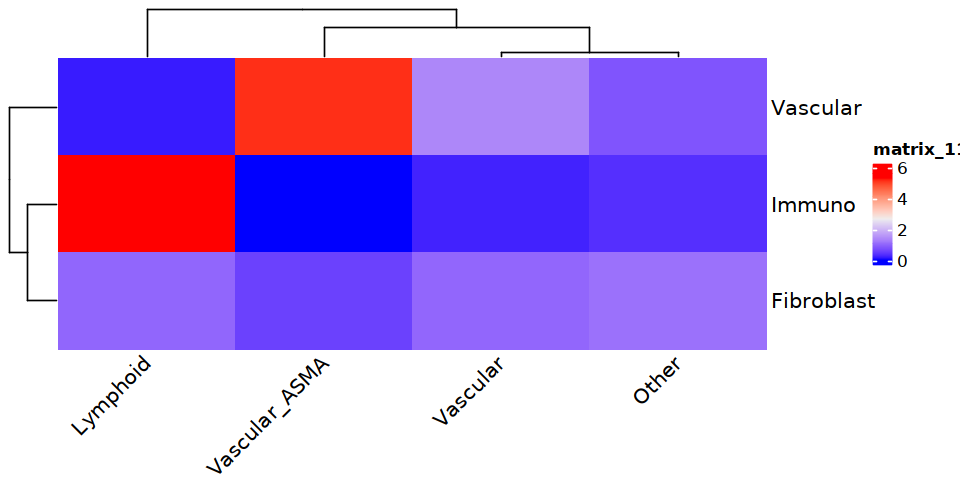

$GI6645

$GI6717

$GI6846


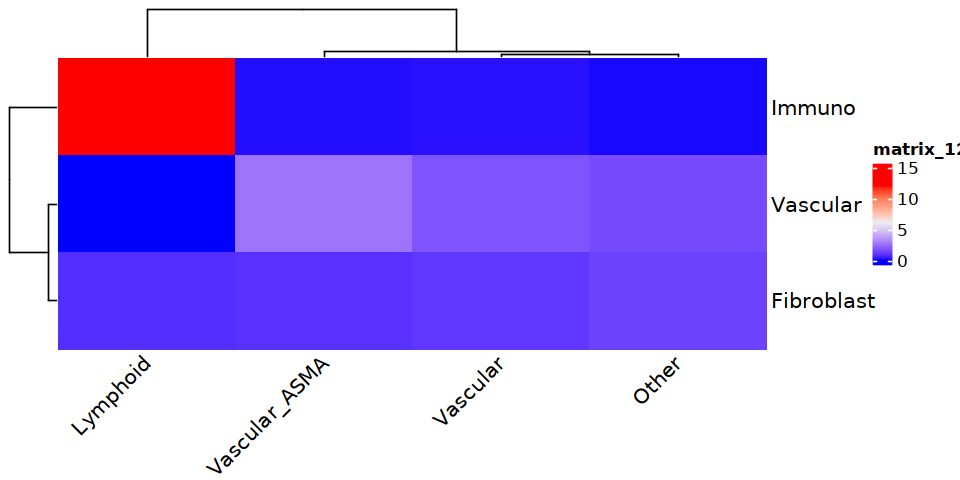

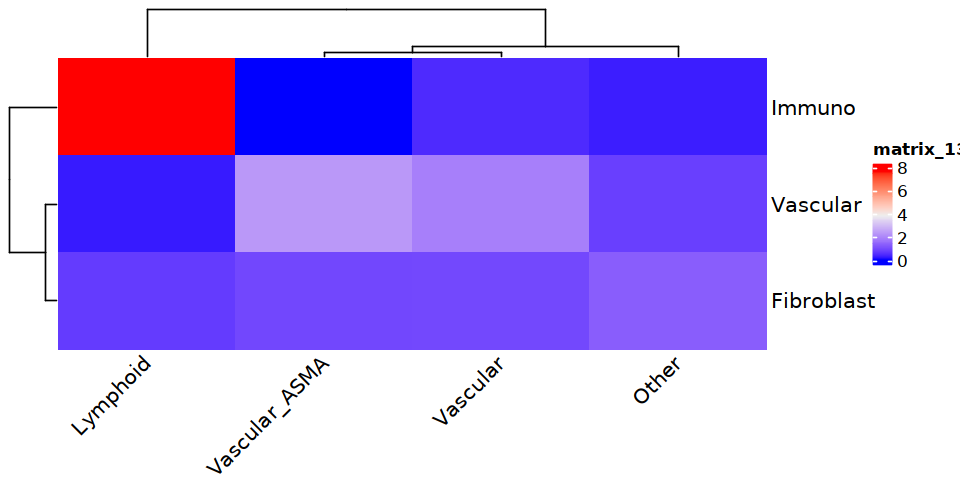

In [97]:
# res_coloc %>% split(.$LibraryID) %>% map(arrange, -estimate) %>% map(head)
fig.size(4, 8)
res_coloc %>% split(.$LibraryID) %>% map(coloc_heatmap)

In [98]:
# fig.size(4, 6)
# coloc_heatmap(res_coloc)

## Nice co-loc plots

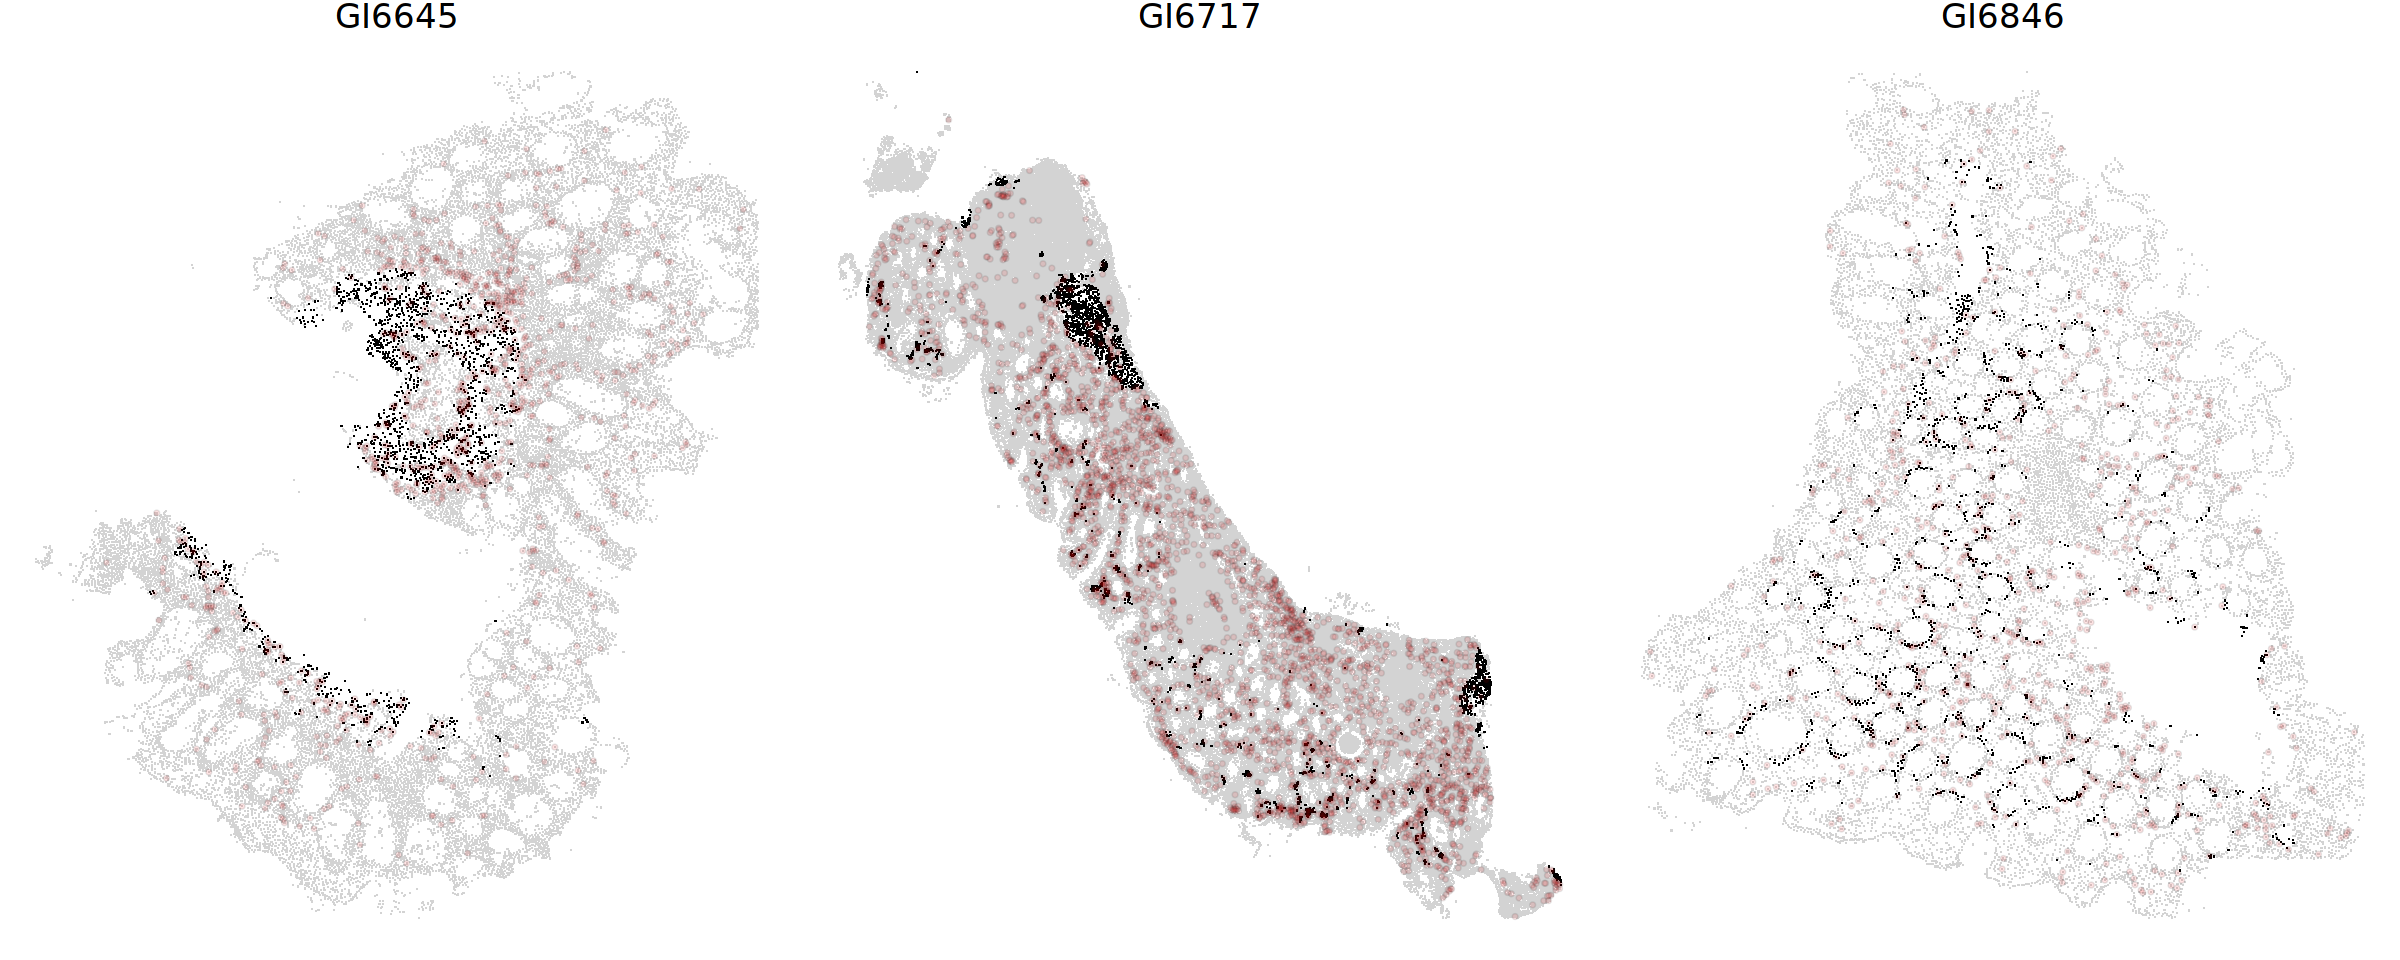

In [103]:
fig.size(8, 20)
nice_plot_coloc(spots, fibroblasts, c('Vascular_ASMA'), 'Vascular')


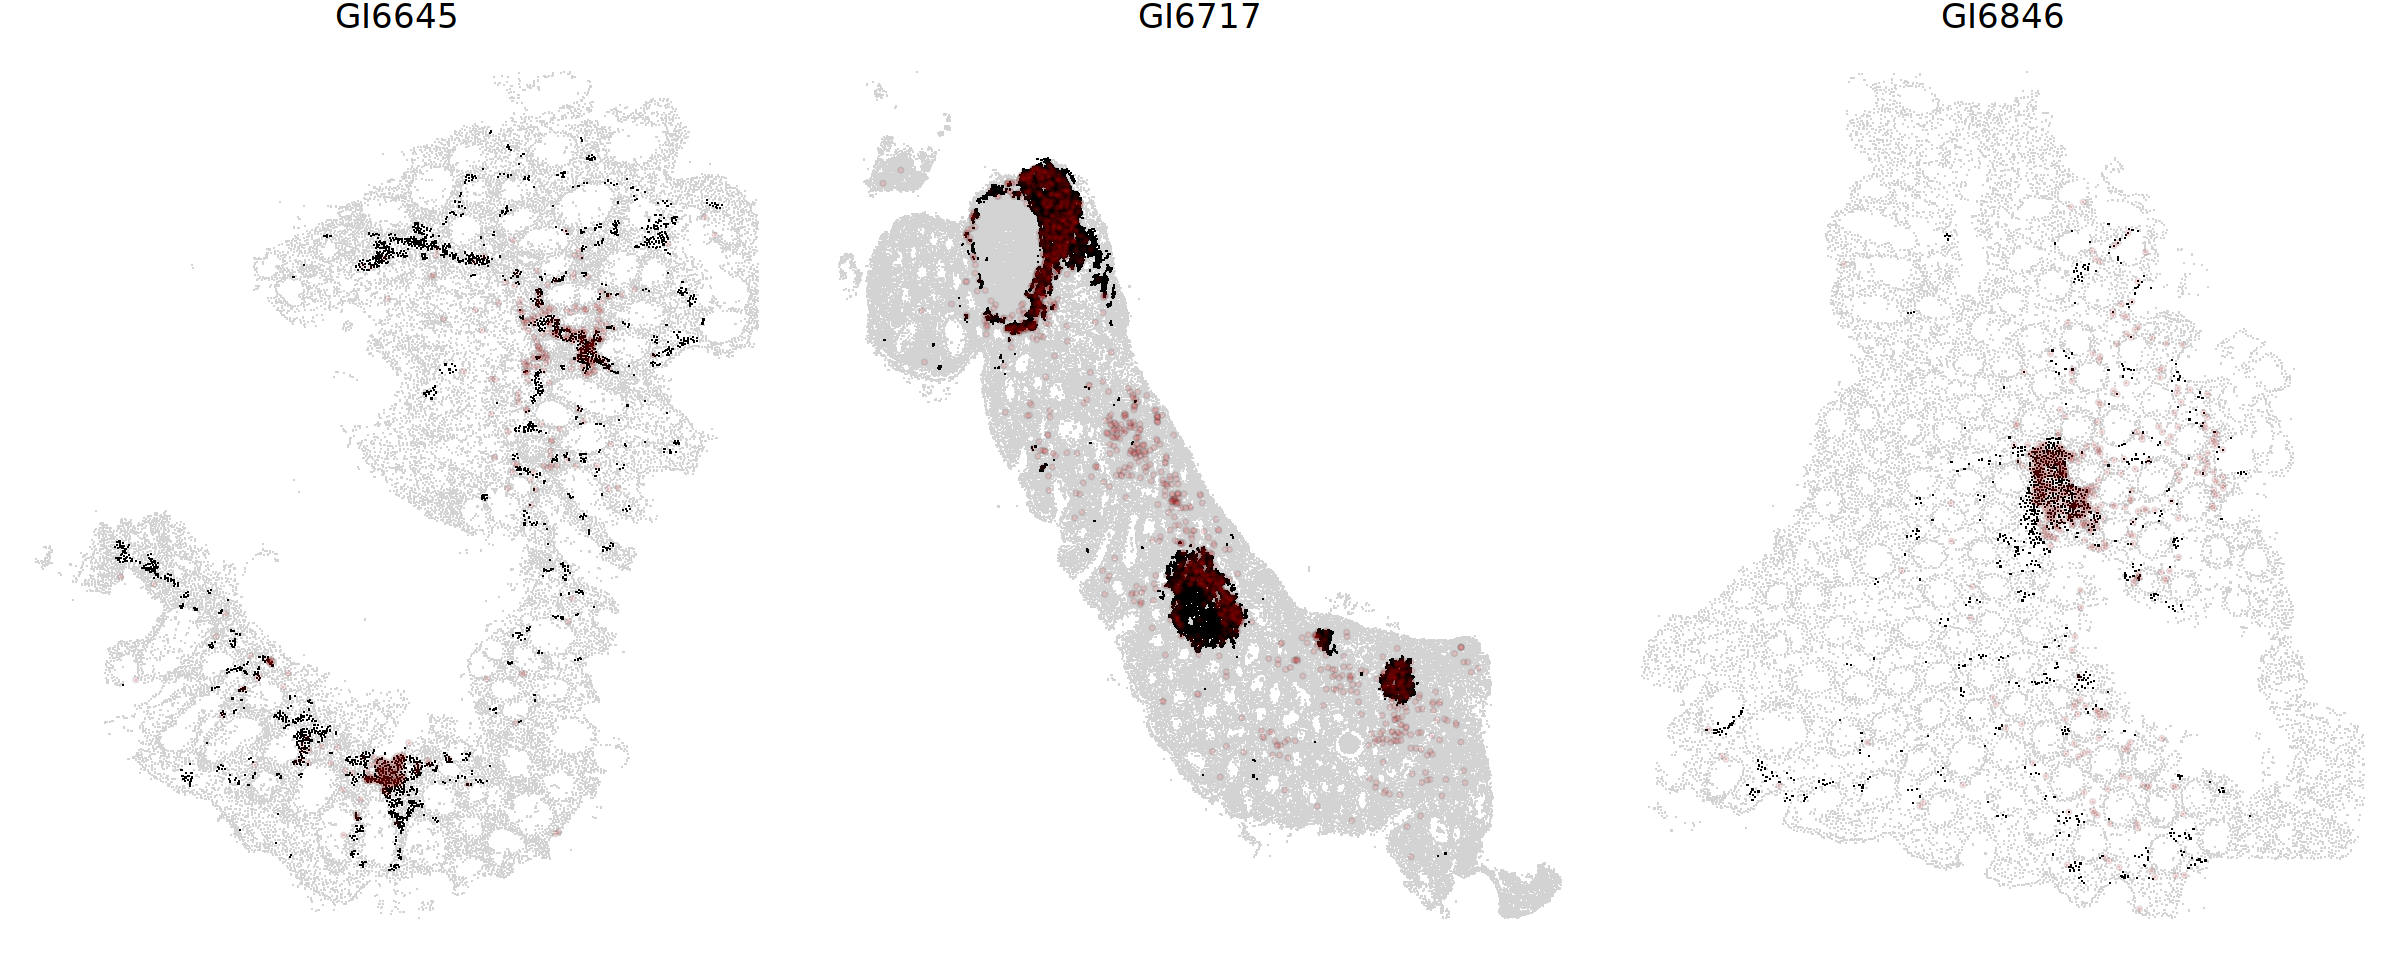

In [100]:
fig.size(8, 20)
nice_plot_coloc(spots, fibroblasts, c('Lymphoid'), 'Immuno')


## Batch

In [101]:
fibroblasts$metadata %>% with(table(LibraryID, Subtype))


         Subtype
LibraryID Fibroblast Immuno Vascular
   GI6645       6523    440     1016
   GI6717      18291   2053     3007
   GI6846       4058    518      775

## Cache

In [110]:
saveRDS(fibroblasts, glue('{datadir}/gut_fibroblasts.rds'))
saveRDS(spots, glue('{datadir}/gut_spots.rds'))
saveRDS(res_coloc, glue('{datadir}/gut_res_coloc.rds'))
